# Experiments on Dai's Framework

In this notebook we study a set of extensions to a basic stopping algorithm by Dai et al.
We analyse the performance and quality according to a set of metrics defined below and we compare with the basic Dai's algorithm.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
def get_approaches_results(datasets, column_mean, column_std, group_by_th = False, items_num = 1000):
    mean = []
    std = []
    #initial
    if group_by_th == True:
        ths = datasets[0]["threshold"]
        for th in ths:
            for data in datasets:
                data = data[data["threshold"]==th]
                if(column_mean == 'cost'):
                    vals = data[column_mean]/data['cost_ratio'][0]/items_num
                    for v in vals:
                        mean.append(v)
                    vals_std = data[column_std]/data['cost_ratio'][0]/items_num
                    for s in vals_std:
                        std.append(s)
                else:
                    vals = data[column_mean]
                    for v in vals:
                        mean.append(v)
                    vals_std = data[column_std]
                    for s in vals_std:
                        std.append(s)
    else:
        for data in datasets:
            if(column_mean == 'cost'):
                vals = data[column_mean]/data['cost_ratio']/items_num
                for v in vals:
                    mean.append(v)
                vals_std = data[column_std]/data['cost_ratio']/items_num
                for s in vals_std:
                    std.append(s)
            else:
                vals = data[column_mean]
                for v in vals:
                    mean.append(v)
                vals_std = data[column_std]
                for s in vals_std:
                    std.append(s)
        
    return mean, std

def get_group_colors(groups, subgroups):
    #colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']
    return np.concatenate([[np.concatenate(np.random.rand(3,1))] * subgroups for x in range(groups)])

def concatenate(list1, list2):
    result = []
    for elem1 in list1:
        result.append(elem1)
        
    for elem2 in list2:
        result.append(elem2)
        
    return result

def get_total_results(list1, list2, column, mv_num=None, cost_ratio=None, decision_fn=None, threshold=None, class_fn=None, c=None, e=None):
    if mv_num != None:
        return concatenate(list1[list1['votes']==mv_num][column].values, 
                           list2[list2['votes']==mv_num][column].values)
    elif c != None:
        return concatenate(list1[list1['c']==c][list1['e']==e][column].values, 
                           list2[list2['c']==c][list2['e']==e][column].values)
    elif class_fn != None:
        return concatenate(list1[list1['class_fn']==class_fn][list1['decision_fn']==decision_fn][list1['cost_ratio']==cost_ratio][list1['threshold']==threshold][column].values, 
                           list2[list2['class_fn']==class_fn][list2['decision_fn']==decision_fn][list2['cost_ratio']==cost_ratio][list2['threshold']==threshold][column].values)
    elif decision_fn != None:
        return concatenate(list1[list1['decision_fn']==decision_fn][list1['cost_ratio']==cost_ratio][list1['threshold']==threshold][column].values, 
                           list2[list2['decision_fn']==decision_fn][list2['cost_ratio']==cost_ratio][list2['threshold']==threshold][column].values)
    else:
        return concatenate(list1[column].values, 
                           list2[column].values)

In [4]:
def plot_elems(elements, columns):
    #Figure 1
    ind = np.arange(len(elems))
    width = .1
    xticks_ind = ind + width / 2
    xticks_rotation = 70
    xticks_names = elems['name']
    
    plt.figure(num=1, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(bottom = .001)
    
    for key,column in enumerate(columns):
        #plot_num = 320 + key
        plt.subplot(3, 2, key+1)
        column_mean = elements[column]
        column_std = elements[f"{column}_std"]

        p1 = plt.bar(ind, column_mean, width, yerr=column_std, zorder=3, color='red', edgecolor='black')
        plt.ylabel(column)
        plt.title(column, fontweight="bold", fontsize=40)
        plt.xticks(xticks_ind, xticks_names, rotation=xticks_rotation, fontsize=30)
        plt.grid(zorder=0)
        if max(elements[column]) > 1:
            plt.yticks(np.arange(0,max(elements[column])+3,1), fontsize=20)
        else:
            plt.yticks(np.arange(0,1.1,.1), fontsize=20)
        #plt.savefig("/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/charts/test", bbox_inches = 'tight', pad_inches = 0)
        
        plt.plot(xticks_ind, column_mean, "k--")
        
    #end for
    plt.tight_layout()
    plt.show()

In [5]:
def plot_elems_comparisson(elements1, elements2, elem1_name, elem2_name, columns):
    
    width = 0.1       # the width of the bars: can also be len(x) sequence
    names1 = [f"{elem1_name}-cost={elem[1]['wrong_cost']}-after={elem[1]['estimate_after']}" for elem in elements1.iterrows()]
    names2 = [f"{elem2_name}-cost={elem[1]['wrong_cost']}-after={elem[1]['estimate_after']}" for elem in elements2.iterrows()]
        
    xticks_names = []
    wc_1 = [elem[1]['wrong_cost'] for elem in elements1.iterrows()]
    ea_1 = [elem[1]['estimate_after'] for elem in elements1.iterrows()]
    wc_2 = [elem[1]['wrong_cost'] for elem in elements2.iterrows()]
    ea_2 = [elem[1]['estimate_after'] for elem in elements2.iterrows()]

    for elem_ind in range(len(elements1[columns[0]])):
        xticks_names.append(f"base-cost={wc_1[elem_ind]}-after={ea_1[elem_ind]}")
        xticks_names.append(f"uncl-cost={wc_2[elem_ind]}-after={ea_2[elem_ind]}")


    xticks_rotation = 90
    plt.figure(num=1, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
    plt.grid(zorder=0)
             
    for key,column in enumerate(columns):
        plt.subplot(3, 2, key+1)
        N = len(elements1[columns[0]])
        ind_1 = np.arange(0, N, 1)
        ind_2 = np.arange(0.5, N, 1)
              
        ind_total = np.arange(0, N,.5)
        
        column_mean_1 = elements1[column]
        column_std_1 = elements1[f"{column}_std"]
        
        column_mean_2 = elements2[column]
        column_std_2 = elements2[f"{column}_std"]
        
        p1 = plt.bar(ind_1, column_mean_1, width, yerr=column_std_1)
        p2 = plt.bar(ind_2, column_mean_2, width, yerr=column_std_2)

        plt.ylabel(column)
        plt.title(f'Comparison {column} | {elem1_name} - {elem2_name}', fontsize=30)
        plt.xticks(ind_total, xticks_names, rotation=xticks_rotation, fontsize=18)
              
        if max(elements1[column]) >= max(elements2[column]):
              elements_max = elements1
        else:
              elements_max = elements2
        
        if max(elements_max[column]) > 1:
            plt.yticks(np.arange(0,max(elements_max[column])+3,1), fontsize=30)
        else:
            plt.yticks(np.arange(0,1.1,.1), fontsize=15)
                    
        plt.legend((p1[0], p2[0]), (elem1_name, elem2_name), fontsize=30)
              
        plt.grid(zorder=0)
    
        #end for
    plt.tight_layout()
    plt.show()

## Metrics: 
 - **Classification cost** Each vote has a cost (assumed to be 1), and we compute the total cost for classifying all items
 - **Weighted classificaiton error = (fpc * FP + fnc * FN + ucc*UC)/N** FP= false positives, FB = false negatives, UC= items left unclassified, N= total number of items on which we reached a decision (or a decision to leave them unclassified), fpc= false positive cost, fnc = false negative cost, ucc=unclassified cost. Notice that loss here is INDEPENDENT of the cost
 - ** Precision and Recall, F1, Fbeta**



## Baselines
- We compare with other baselines, which are:
 - fixed number of votes
 - two and break the tie
 - stop after S consecutive same votes
 - stop when difference among two classes greater than X

## Extensions to Dai's framework:
We consider the following extensions

- Varying the cost for giving the wrong answer (this means varying fpc and fnc)
- Dai divides the continuous space of (difficulty, true label) in (11*2)+1 discrete classes, we explore what happens as we reduce or increase this number
- We add one more action, which is leave the items unclassified.
- We experiment in sceanrios with varying error rates distribution for the workers
- We use workers confusion matrix for error rates as opposed to "plain" error rates that are independent of the true label
- we explore the above over a variety of real and simulated datasets
- We experiment with balanced and unbalanced datasets
- We experiment with adding a prior based on an estimation of the dataset balance
- (Future: see what changes for multi predicate)
- **Estimate after ('after' in plots) means that workers error rate $\gamma$ estimation using EM starts after submitting the first answer, otherwise we try estimating $\gamma$ after collecting 2 votes over an item** We compare with Dai's who i) they take one vote per item at each iteration, ii) they re-estimate error rates ONLY after doing the transitions. We want to see what happens if we do that before.

### 1. Try POMDP models with different rewards

In this set of experiments we consider how POMDP performs with respect to the baselines, on our set of test datasets, and we vary the two parameters, **fnc** and **fpc**.

Also, for all experiments, we test the difference between conputing error rates (running EM) before or after updating the POMDP

## Experiment settings
### POMDP definition: 
 - States: 23
 - Actions: 3 = {RequestVote, SubmitFalse, SubmitTrue}
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Beta = fnc/fpc 
 
 

Workers:
 - Binary classification
 - 1000 items
 - average number of votes per worker: (5, 10, 20)
 - Error rate distribution: $\gamma \sim Normal(1, 0.2)$
 - Accuracy ±75%
 
Variations of the experiment:
 - fpc = fnc = {-1, -10, -20, -50, -500, -1000}
 - same for fpc, but we make fnc = fpc * 10, and fnc = fpc * 100
 - as the error rate distribution varies

 

         name  estimate_after    cost  recall  precision   loss     f1  fbeta
0    base-c10           False   1.000   0.762      0.757  0.719  0.759  0.761
1    base-c20           False   1.000   0.751      0.757  0.743  0.754  0.751
2    base-c50           False   2.763   0.862      0.872  0.408  0.867  0.863
3   base-c500           False   7.925   0.985      0.985  0.044  0.985  0.985
4  base-c1000           False  10.286   0.995      0.993  0.015  0.994  0.995
5    base-c10            True   1.000   0.741      0.751  0.770  0.746  0.741
6    base-c20            True   1.000   0.760      0.758  0.721  0.759  0.760
7    base-c50            True   3.020   0.893      0.894  0.319  0.894  0.893
8   base-c500            True   9.613   0.995      0.994  0.017  0.994  0.995
9  base-c1000            True  12.224   0.998      0.999  0.005  0.999  0.998


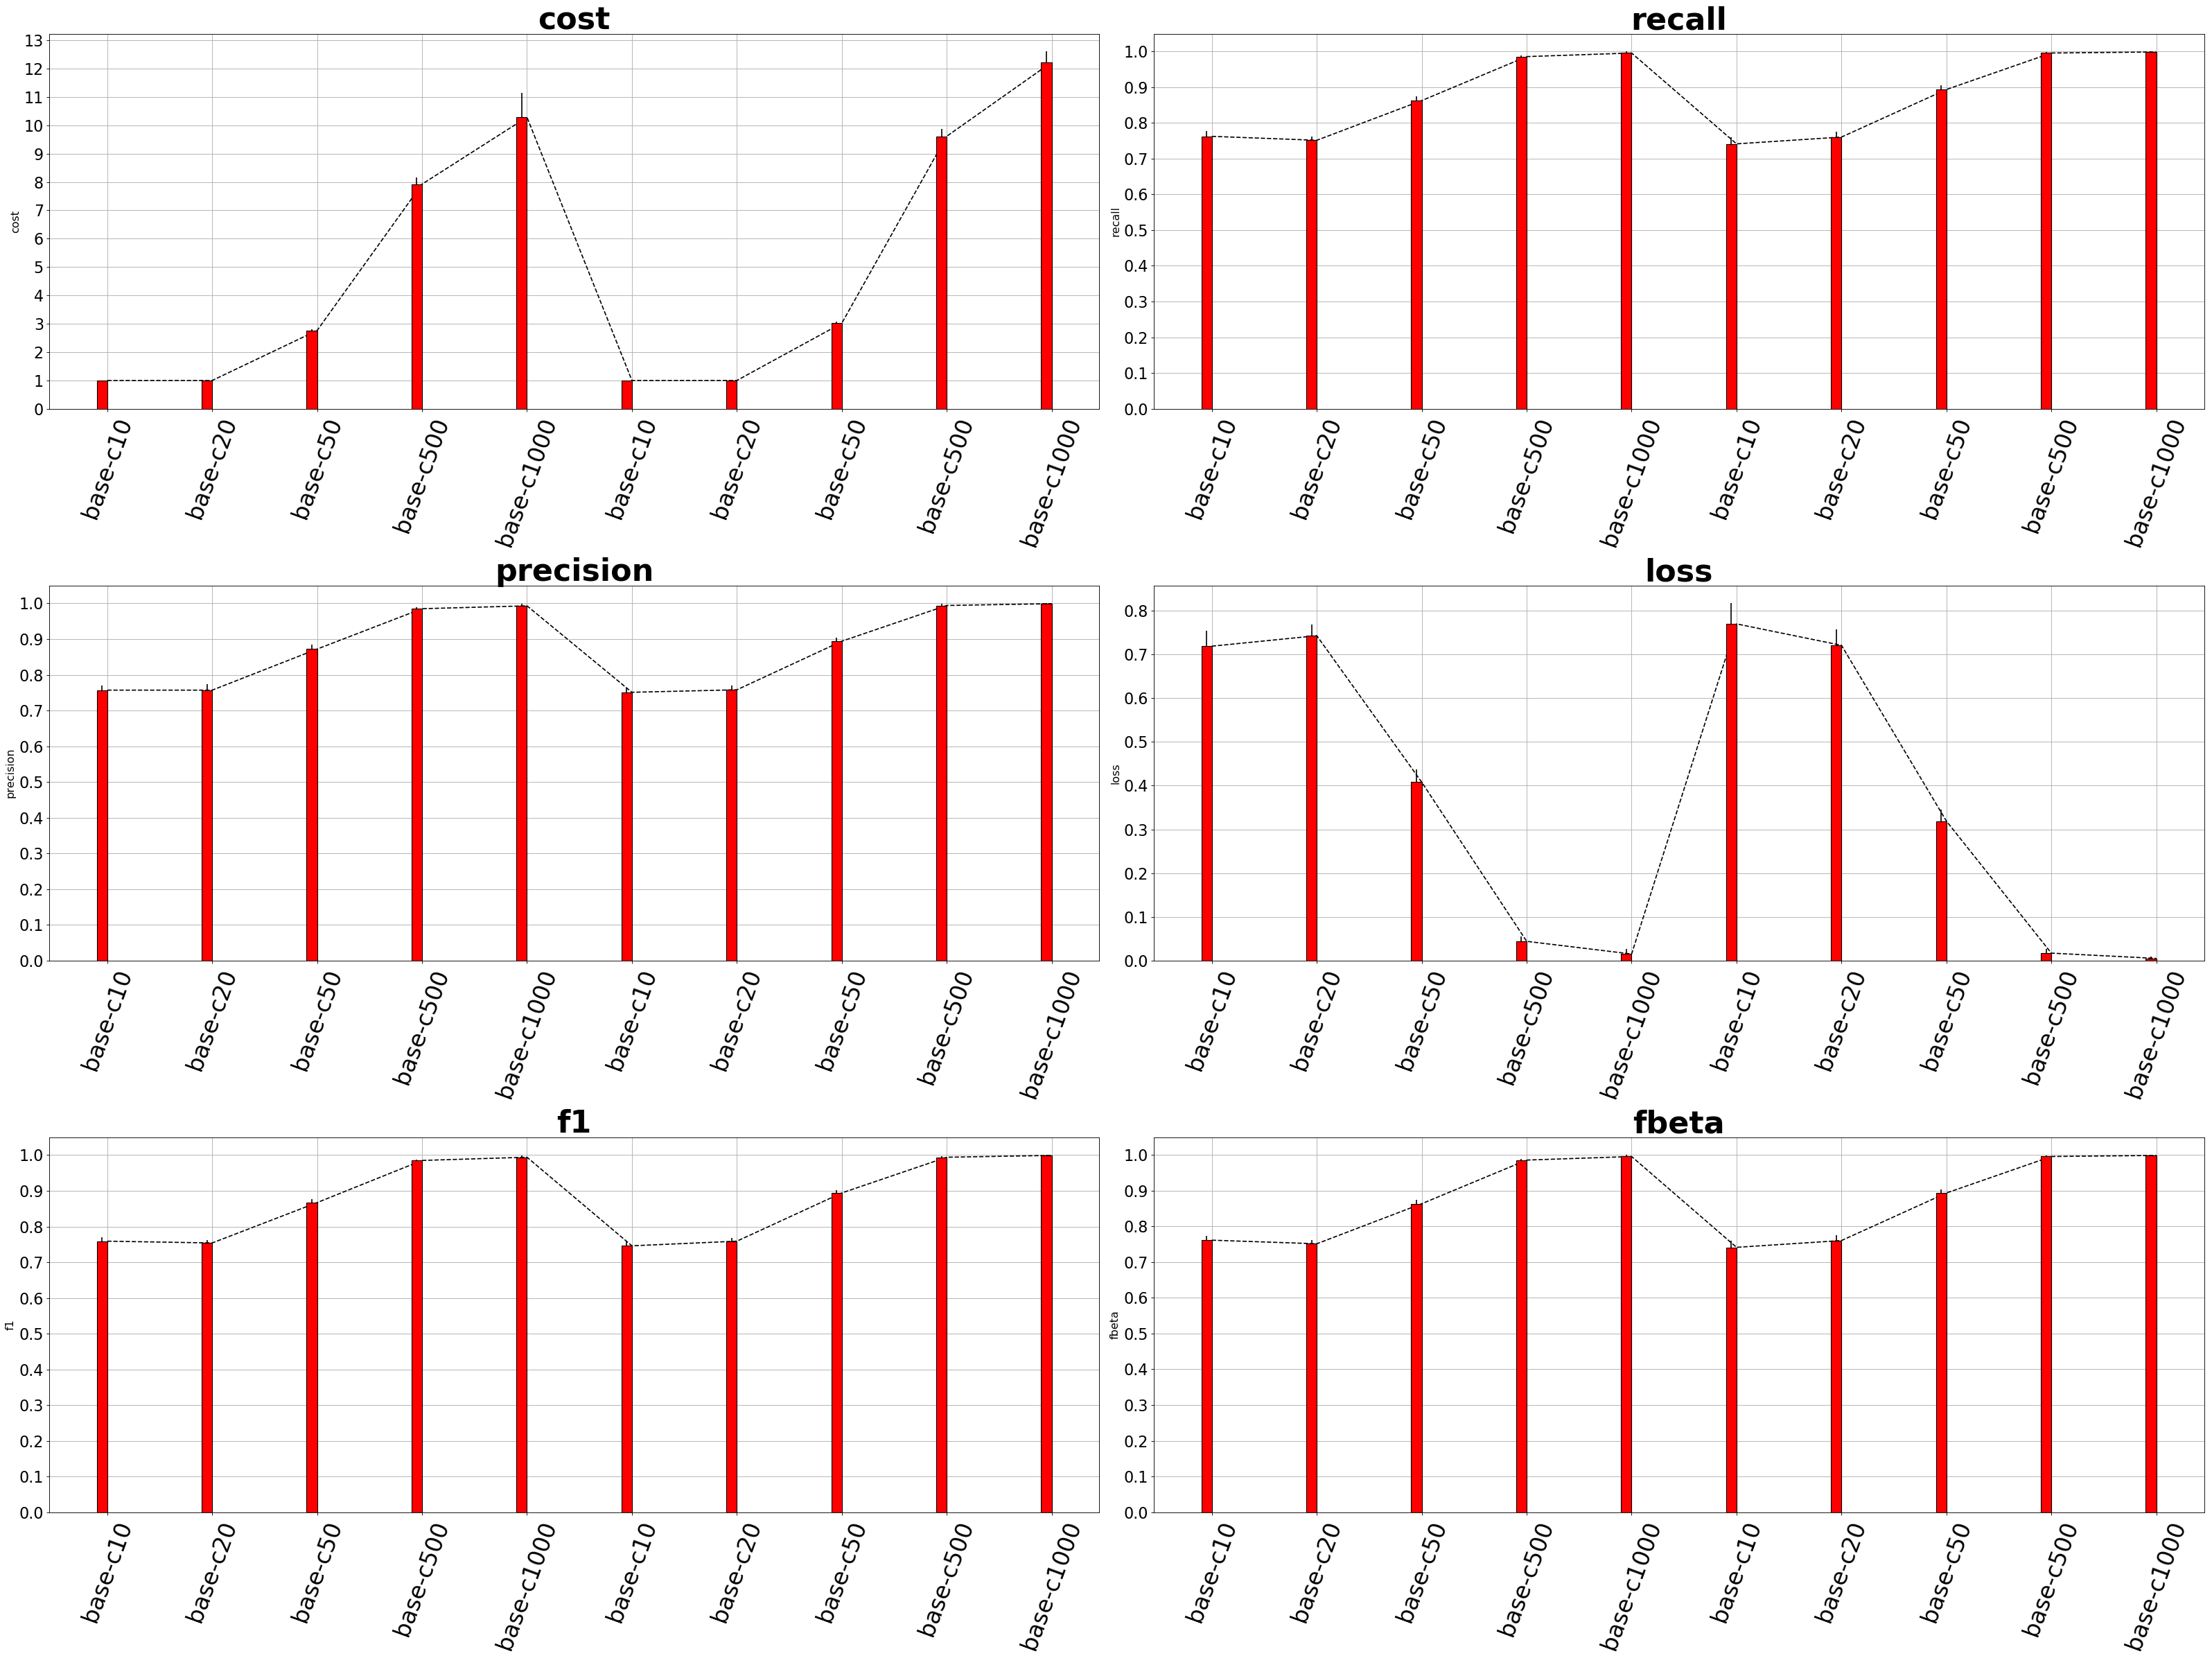

In [403]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('base-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

#### Conclusions:
    - When the wrong answer reward increments, the money cost increments 
    - Higher wrong answer cost/money cost increments quality and reduces loss
    - The quality difference between using a wrong answer cost = 500 and higher is minimal, but when higher increments the money cost 

## 2. Test with different number of states in the model of MDP

POMDP definition: 
 - States #: {5,9,13,17}
     (difficulty, true_label)
    - 5:  (0,0)(1,0)(0,1)(1,1)(T)
    - 9:  (0,0)(0.33,0)(0.66,0)(1,0)(0,1)(0.33,1)(0.66,1)(1,1)(T)
    - 13: (0,0)(0.2,0)(0.4,0)(0.6,0)(0.8,0)(1,0)(0,1)(0.2,1)(0.4,1)(0.6,1)(0.8,1)(1,1)(T)
    - 17: (0,0)(0.15,0)(0.3,0)(0.45,0)(0.6,0)(0.75,0)(0.9,0)(1,0)(0,1)(0.15,1)(0.3,1)(0.45,1)(0.6,1)(0.75,1)(0.9,1)(1,1)(T)
    
    
 - Actions: 4 = {RequestVote, SubmitFalse, SubmitTrue}
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: -500

Workers:
 - Amount: 100
 - Error rate distribution: $\gamma \sim Normal(1, 0.2)$


 
------------------------------------------------------------------------------------------
 
Num States: 5
 


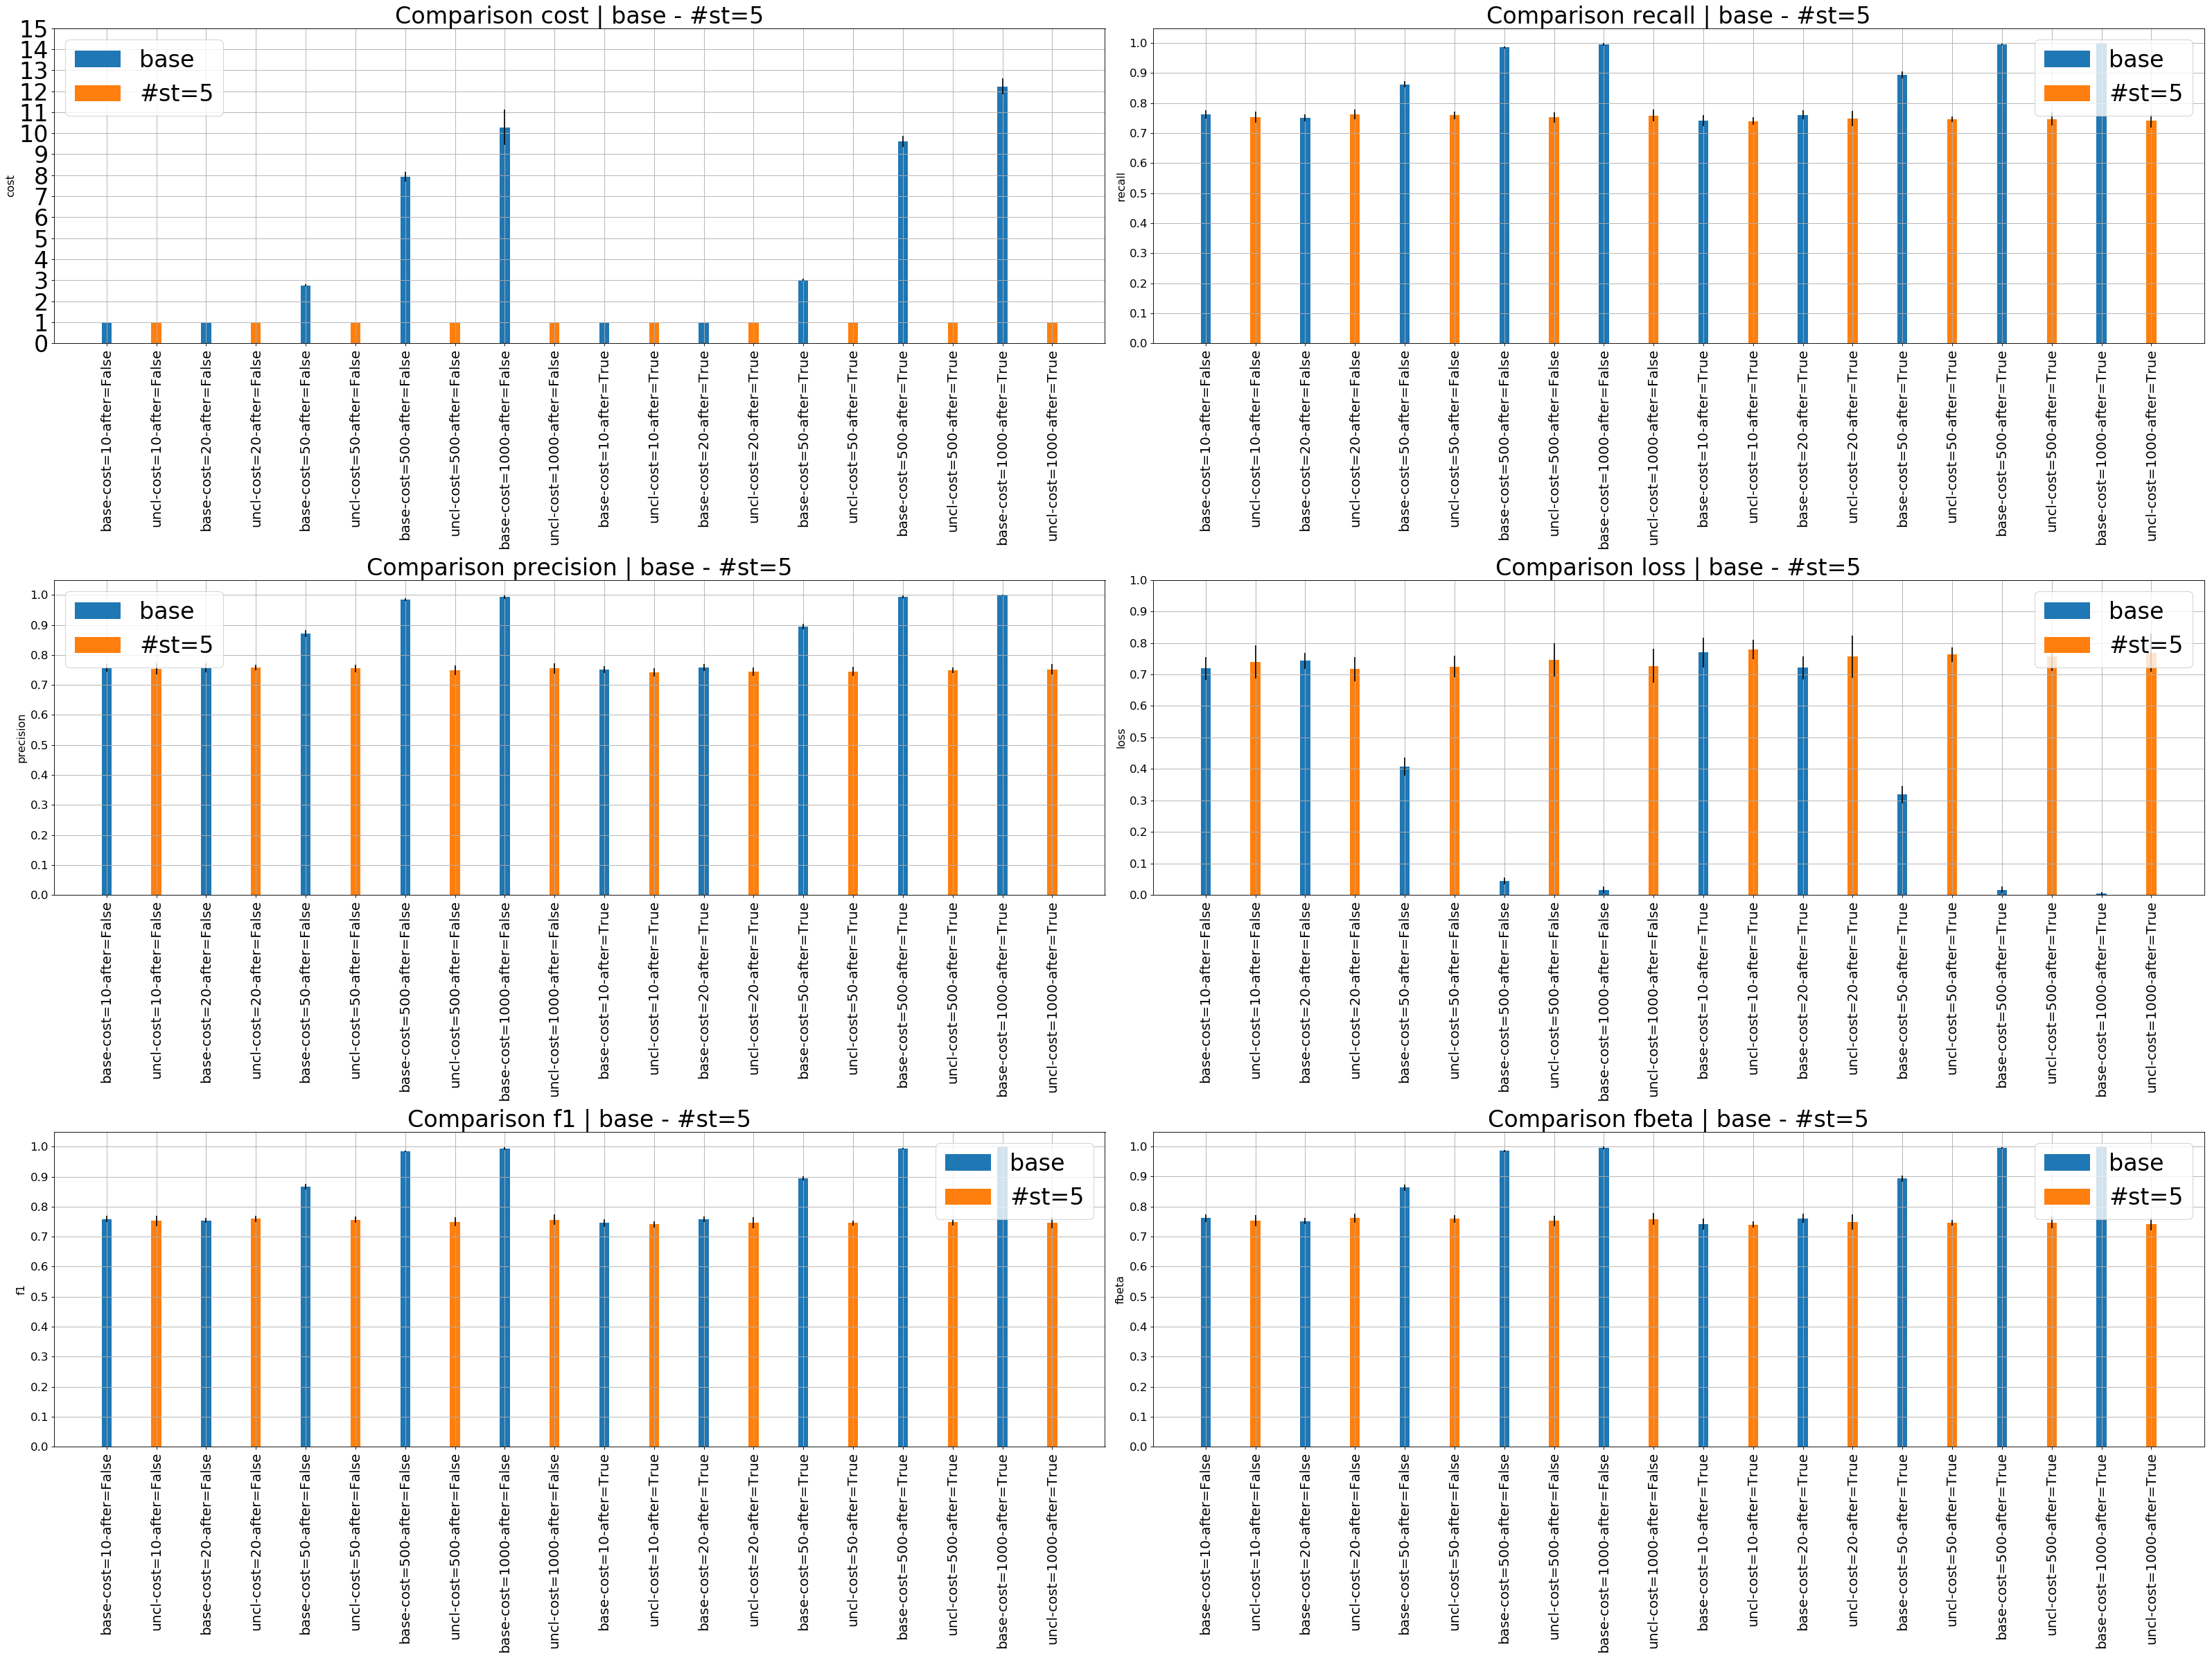

 
------------------------------------------------------------------------------------------
 
Num States: 9
 


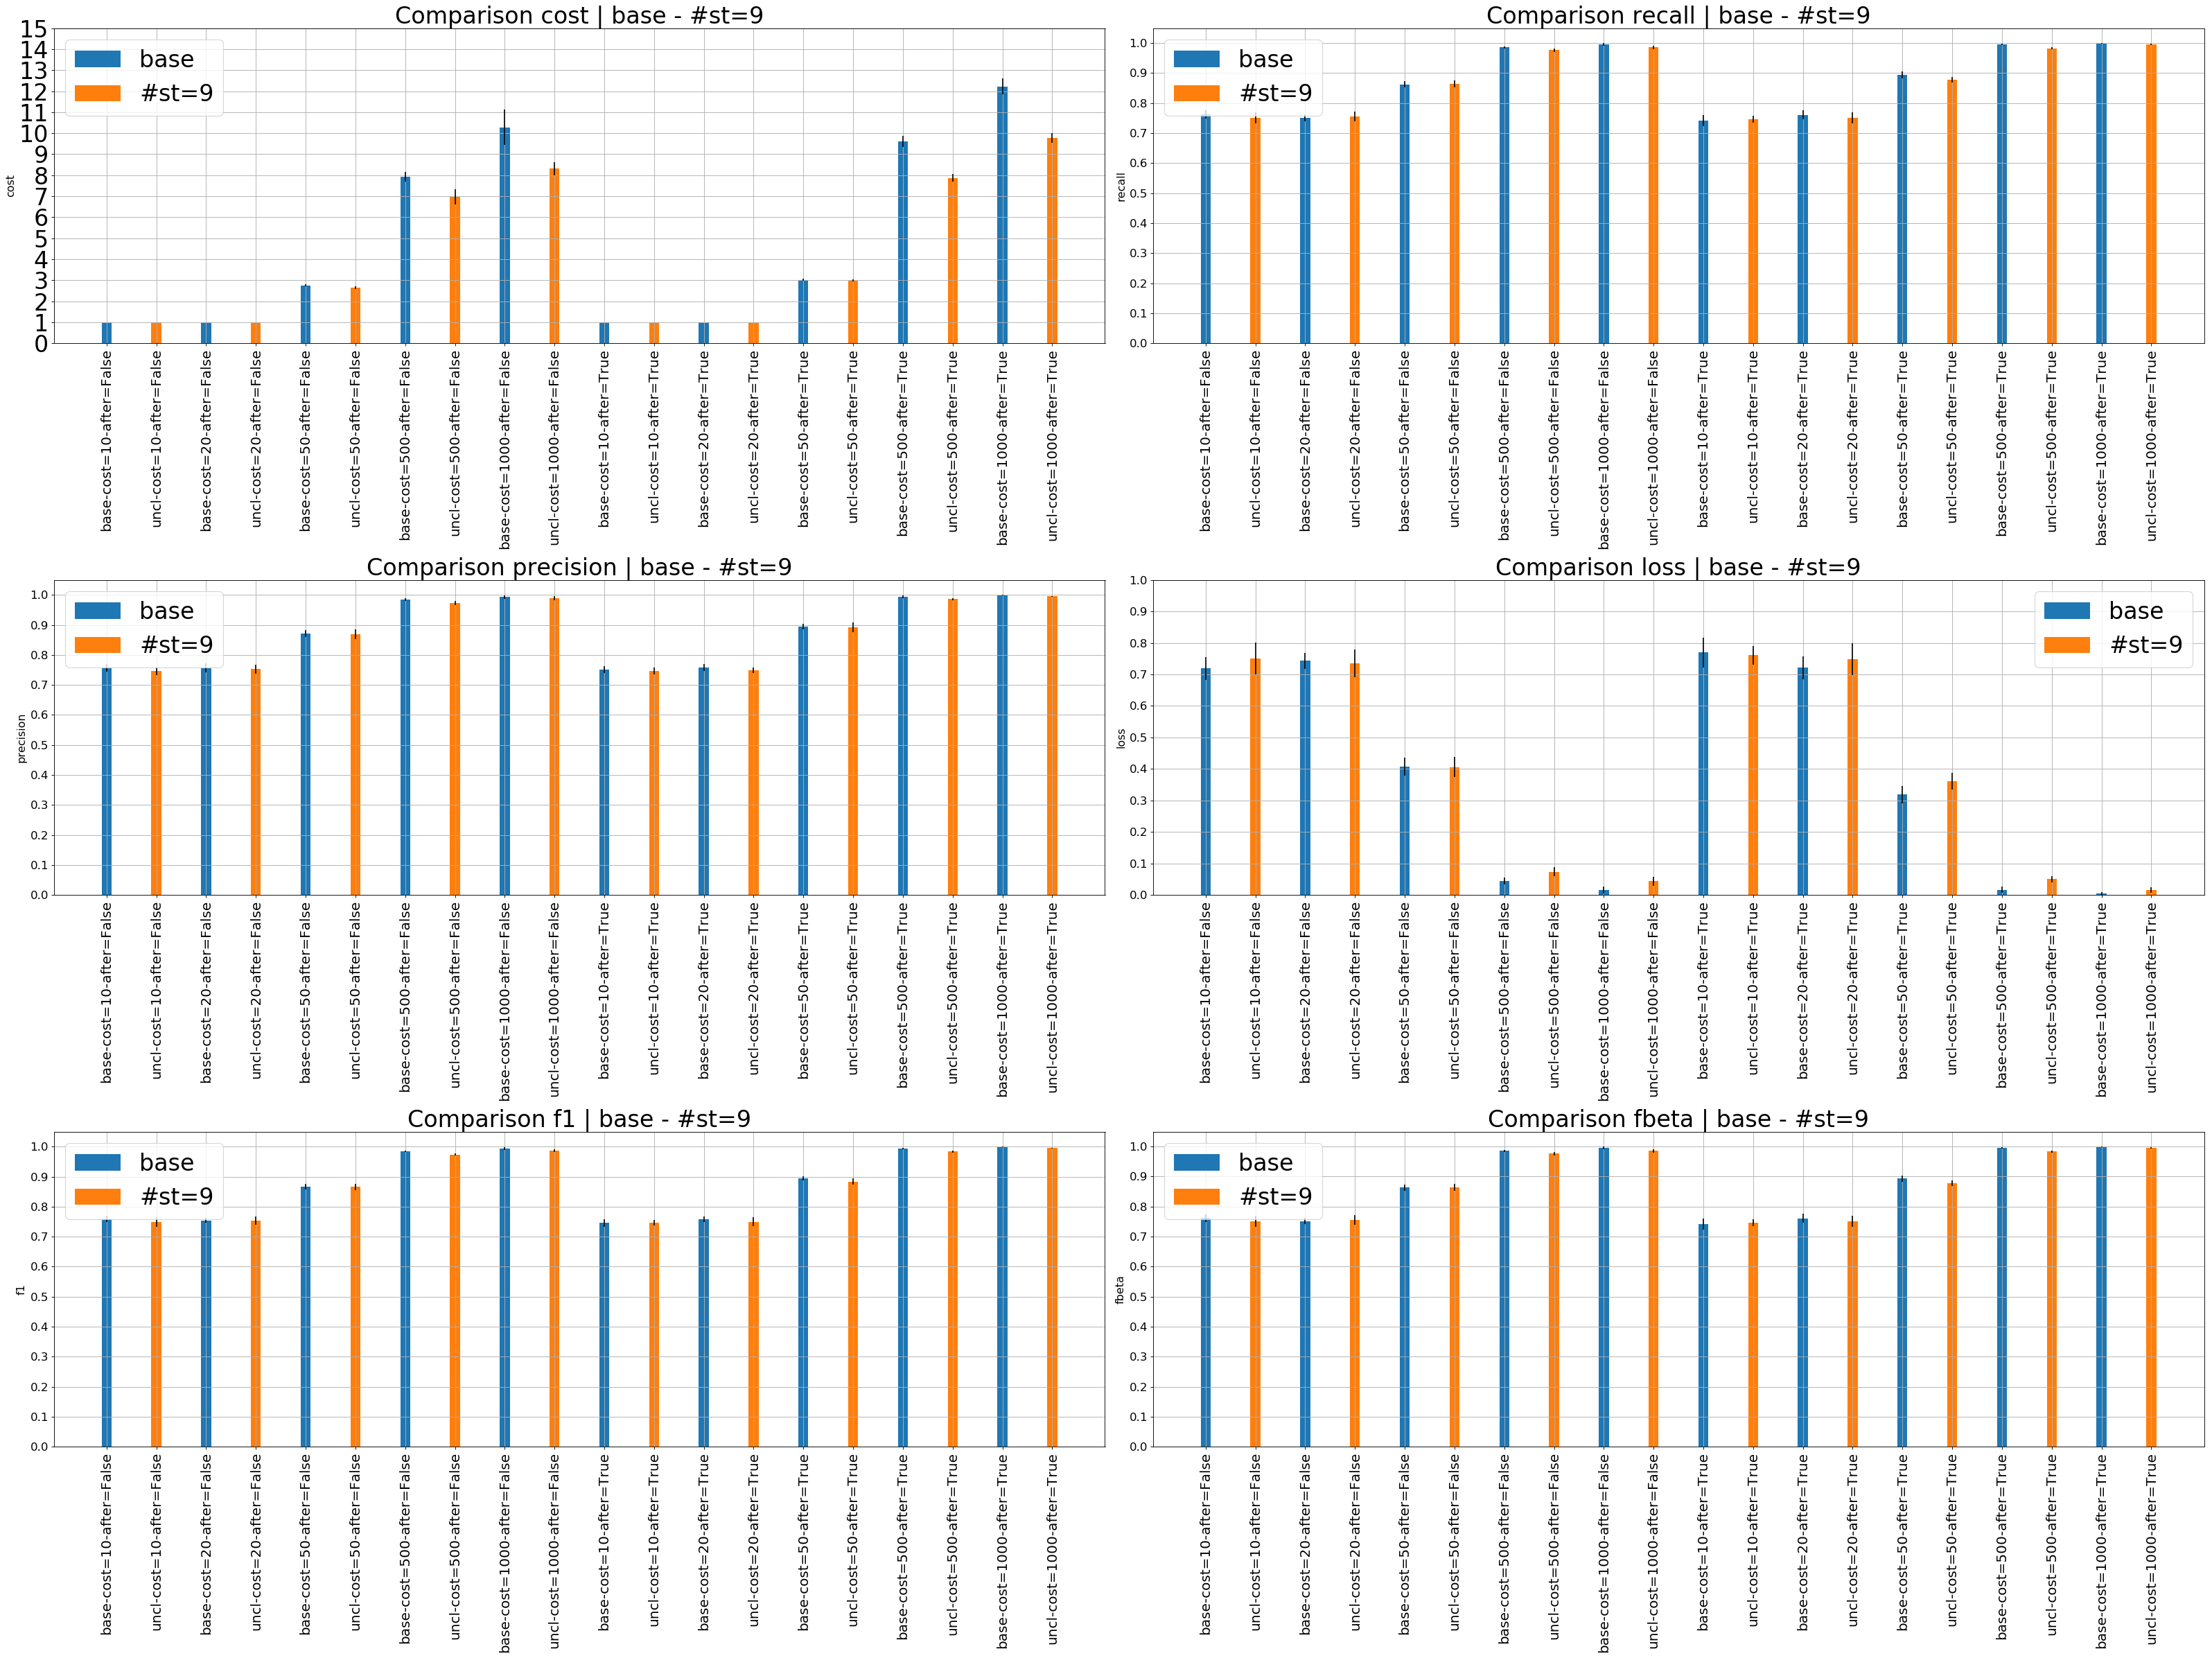

 
------------------------------------------------------------------------------------------
 
Num States: 13
 


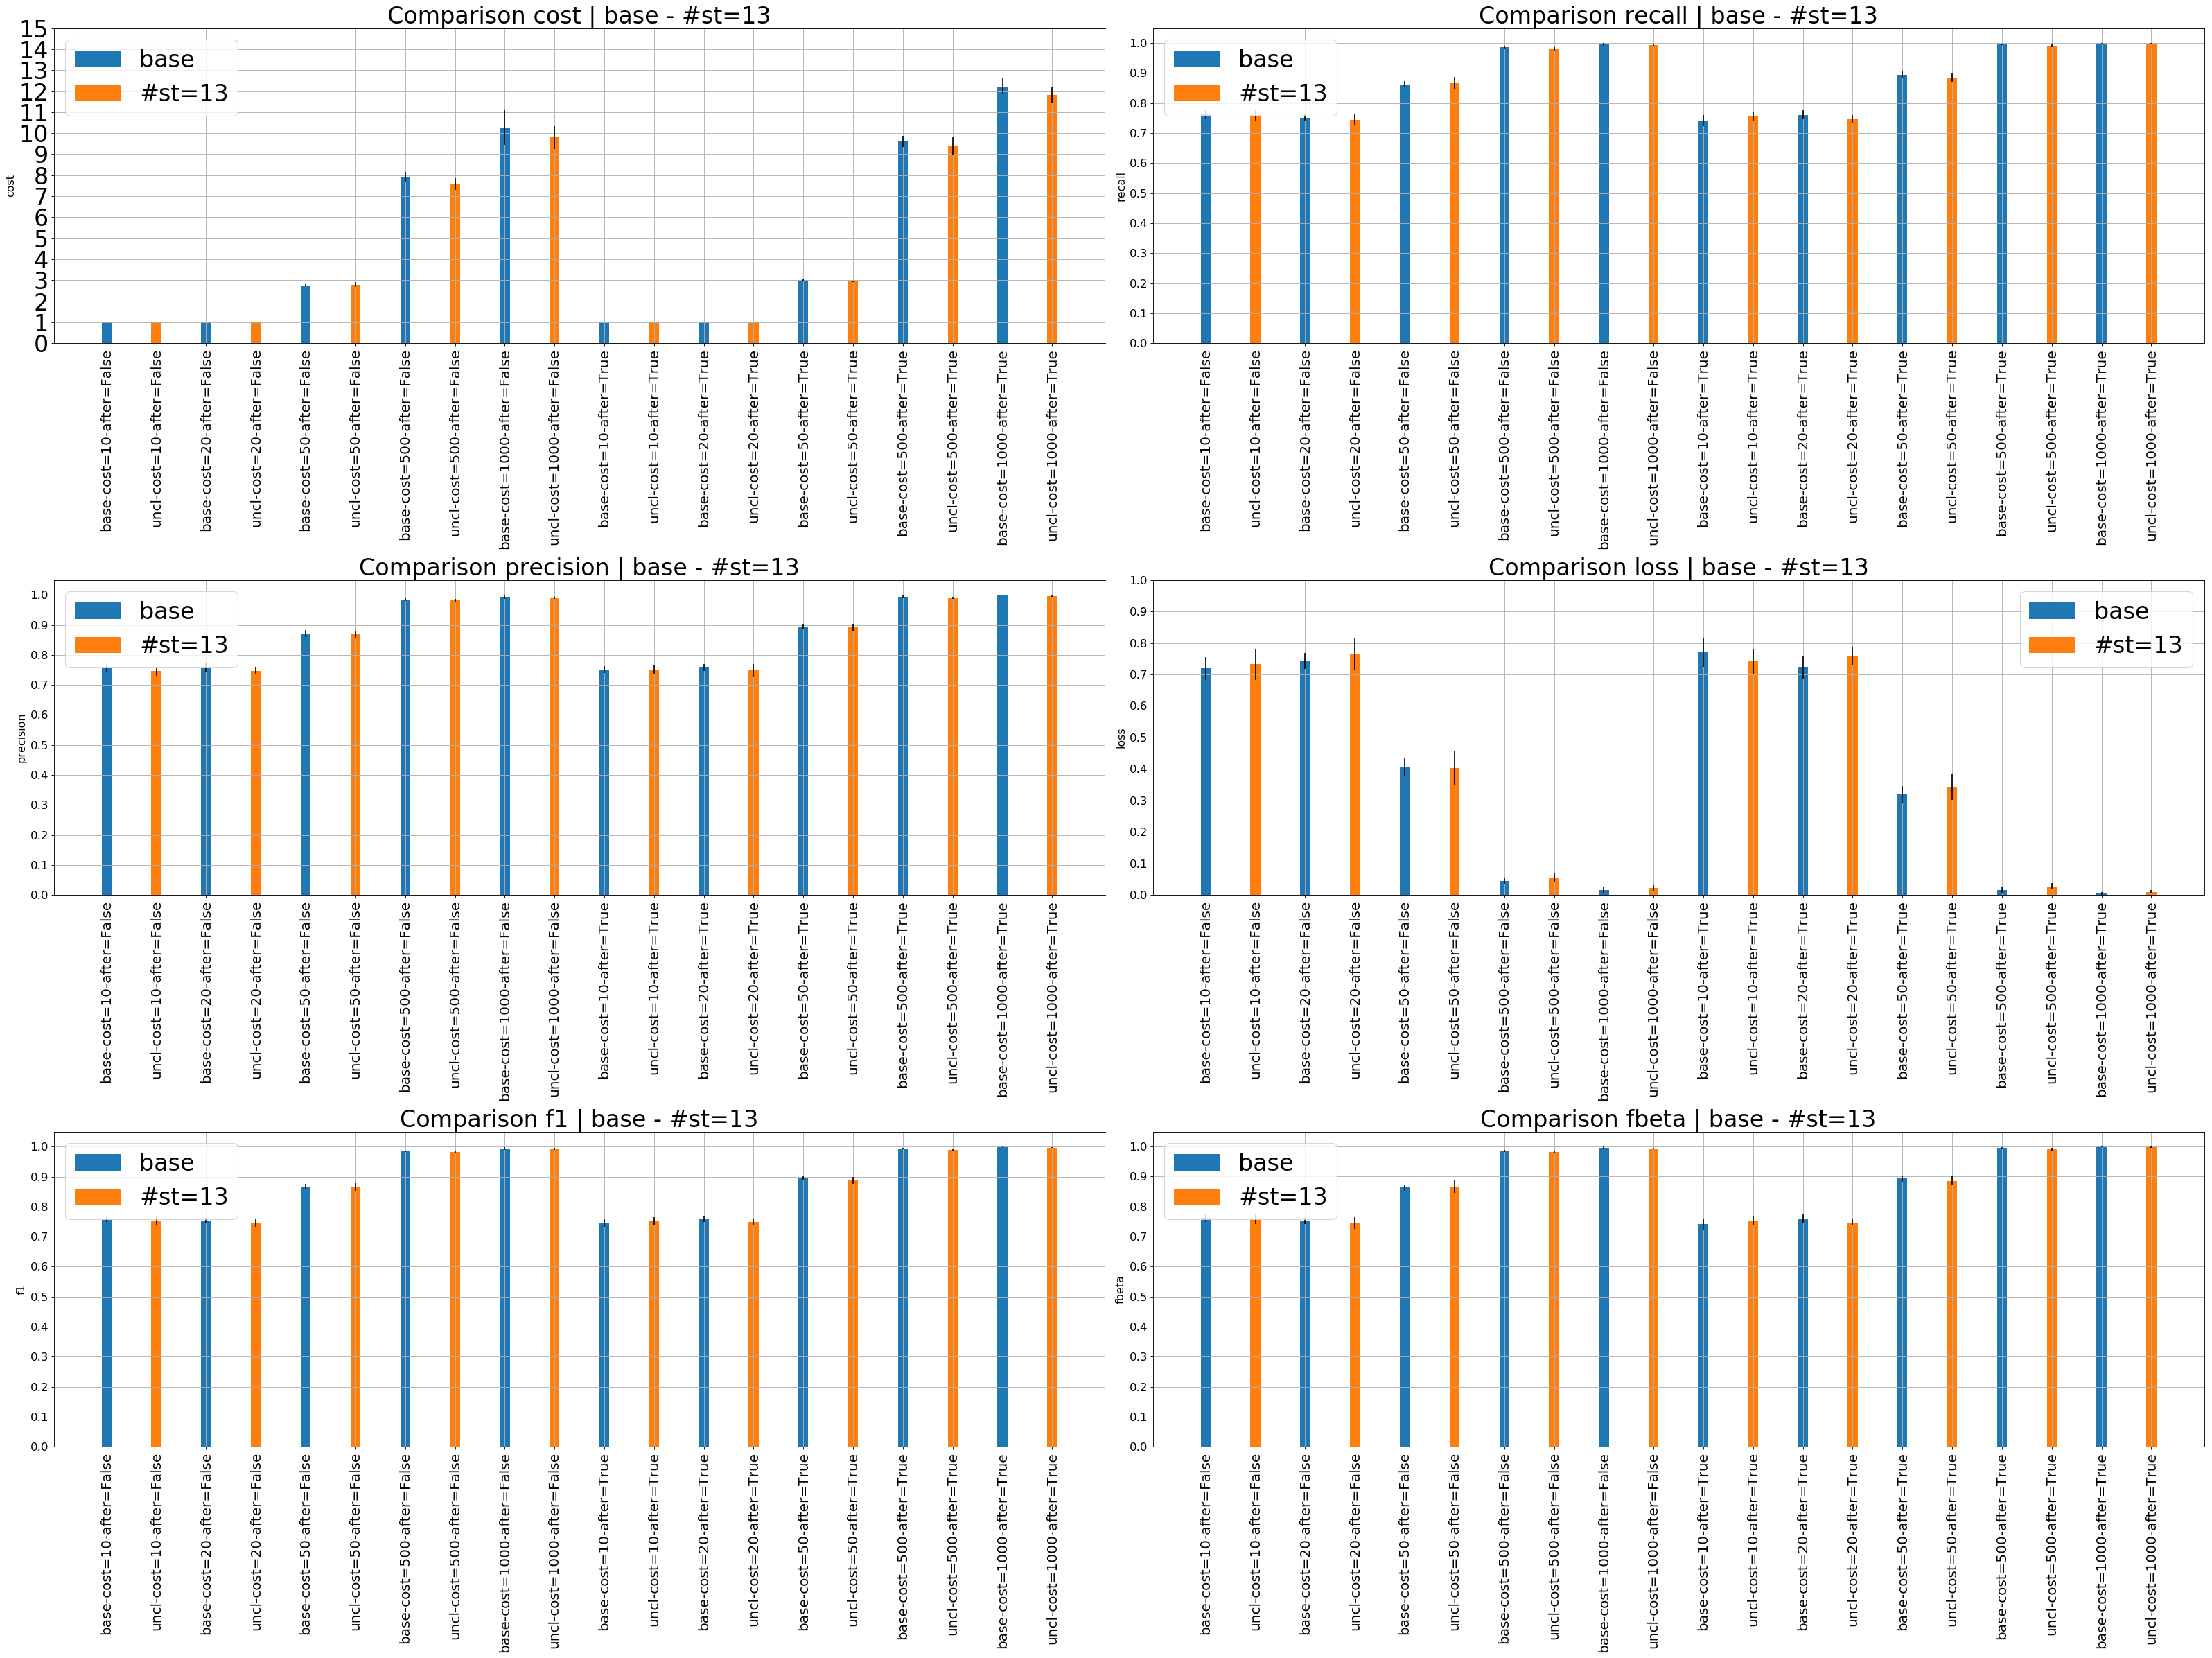

 
------------------------------------------------------------------------------------------
 
Num States: 17
 


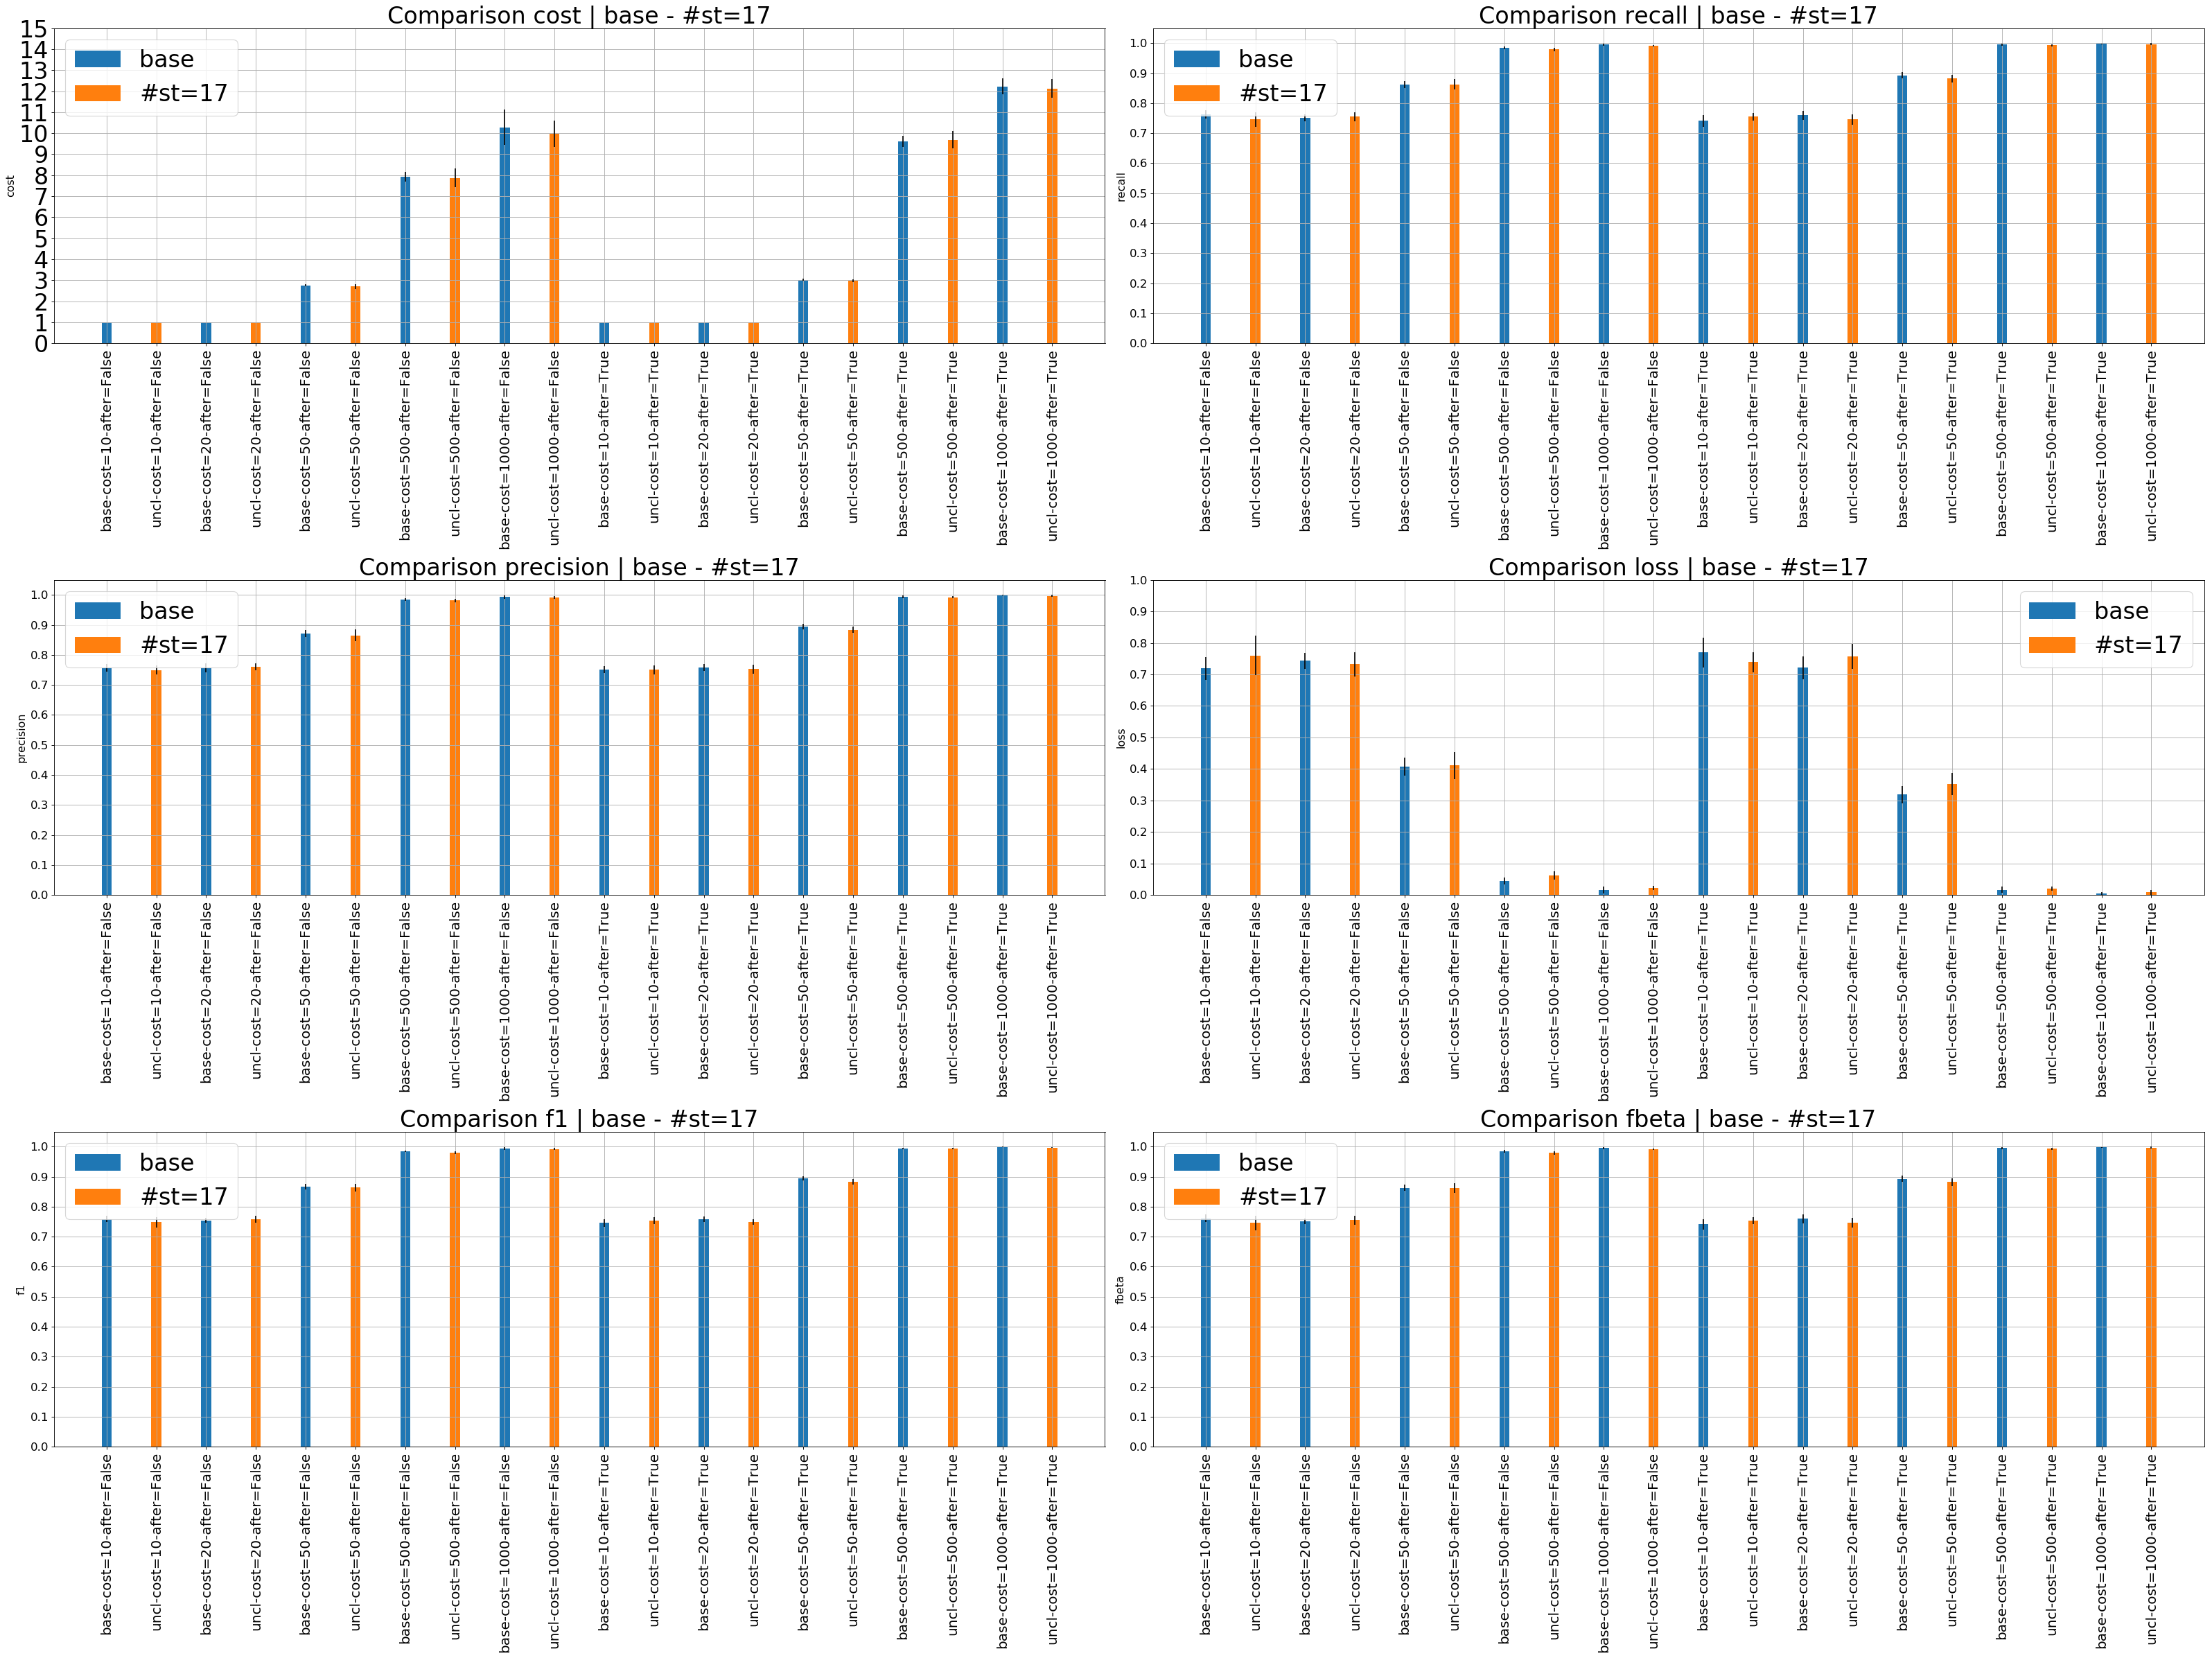

 
------------------------------------------------------------------------------------------
 
Num States: 43
 


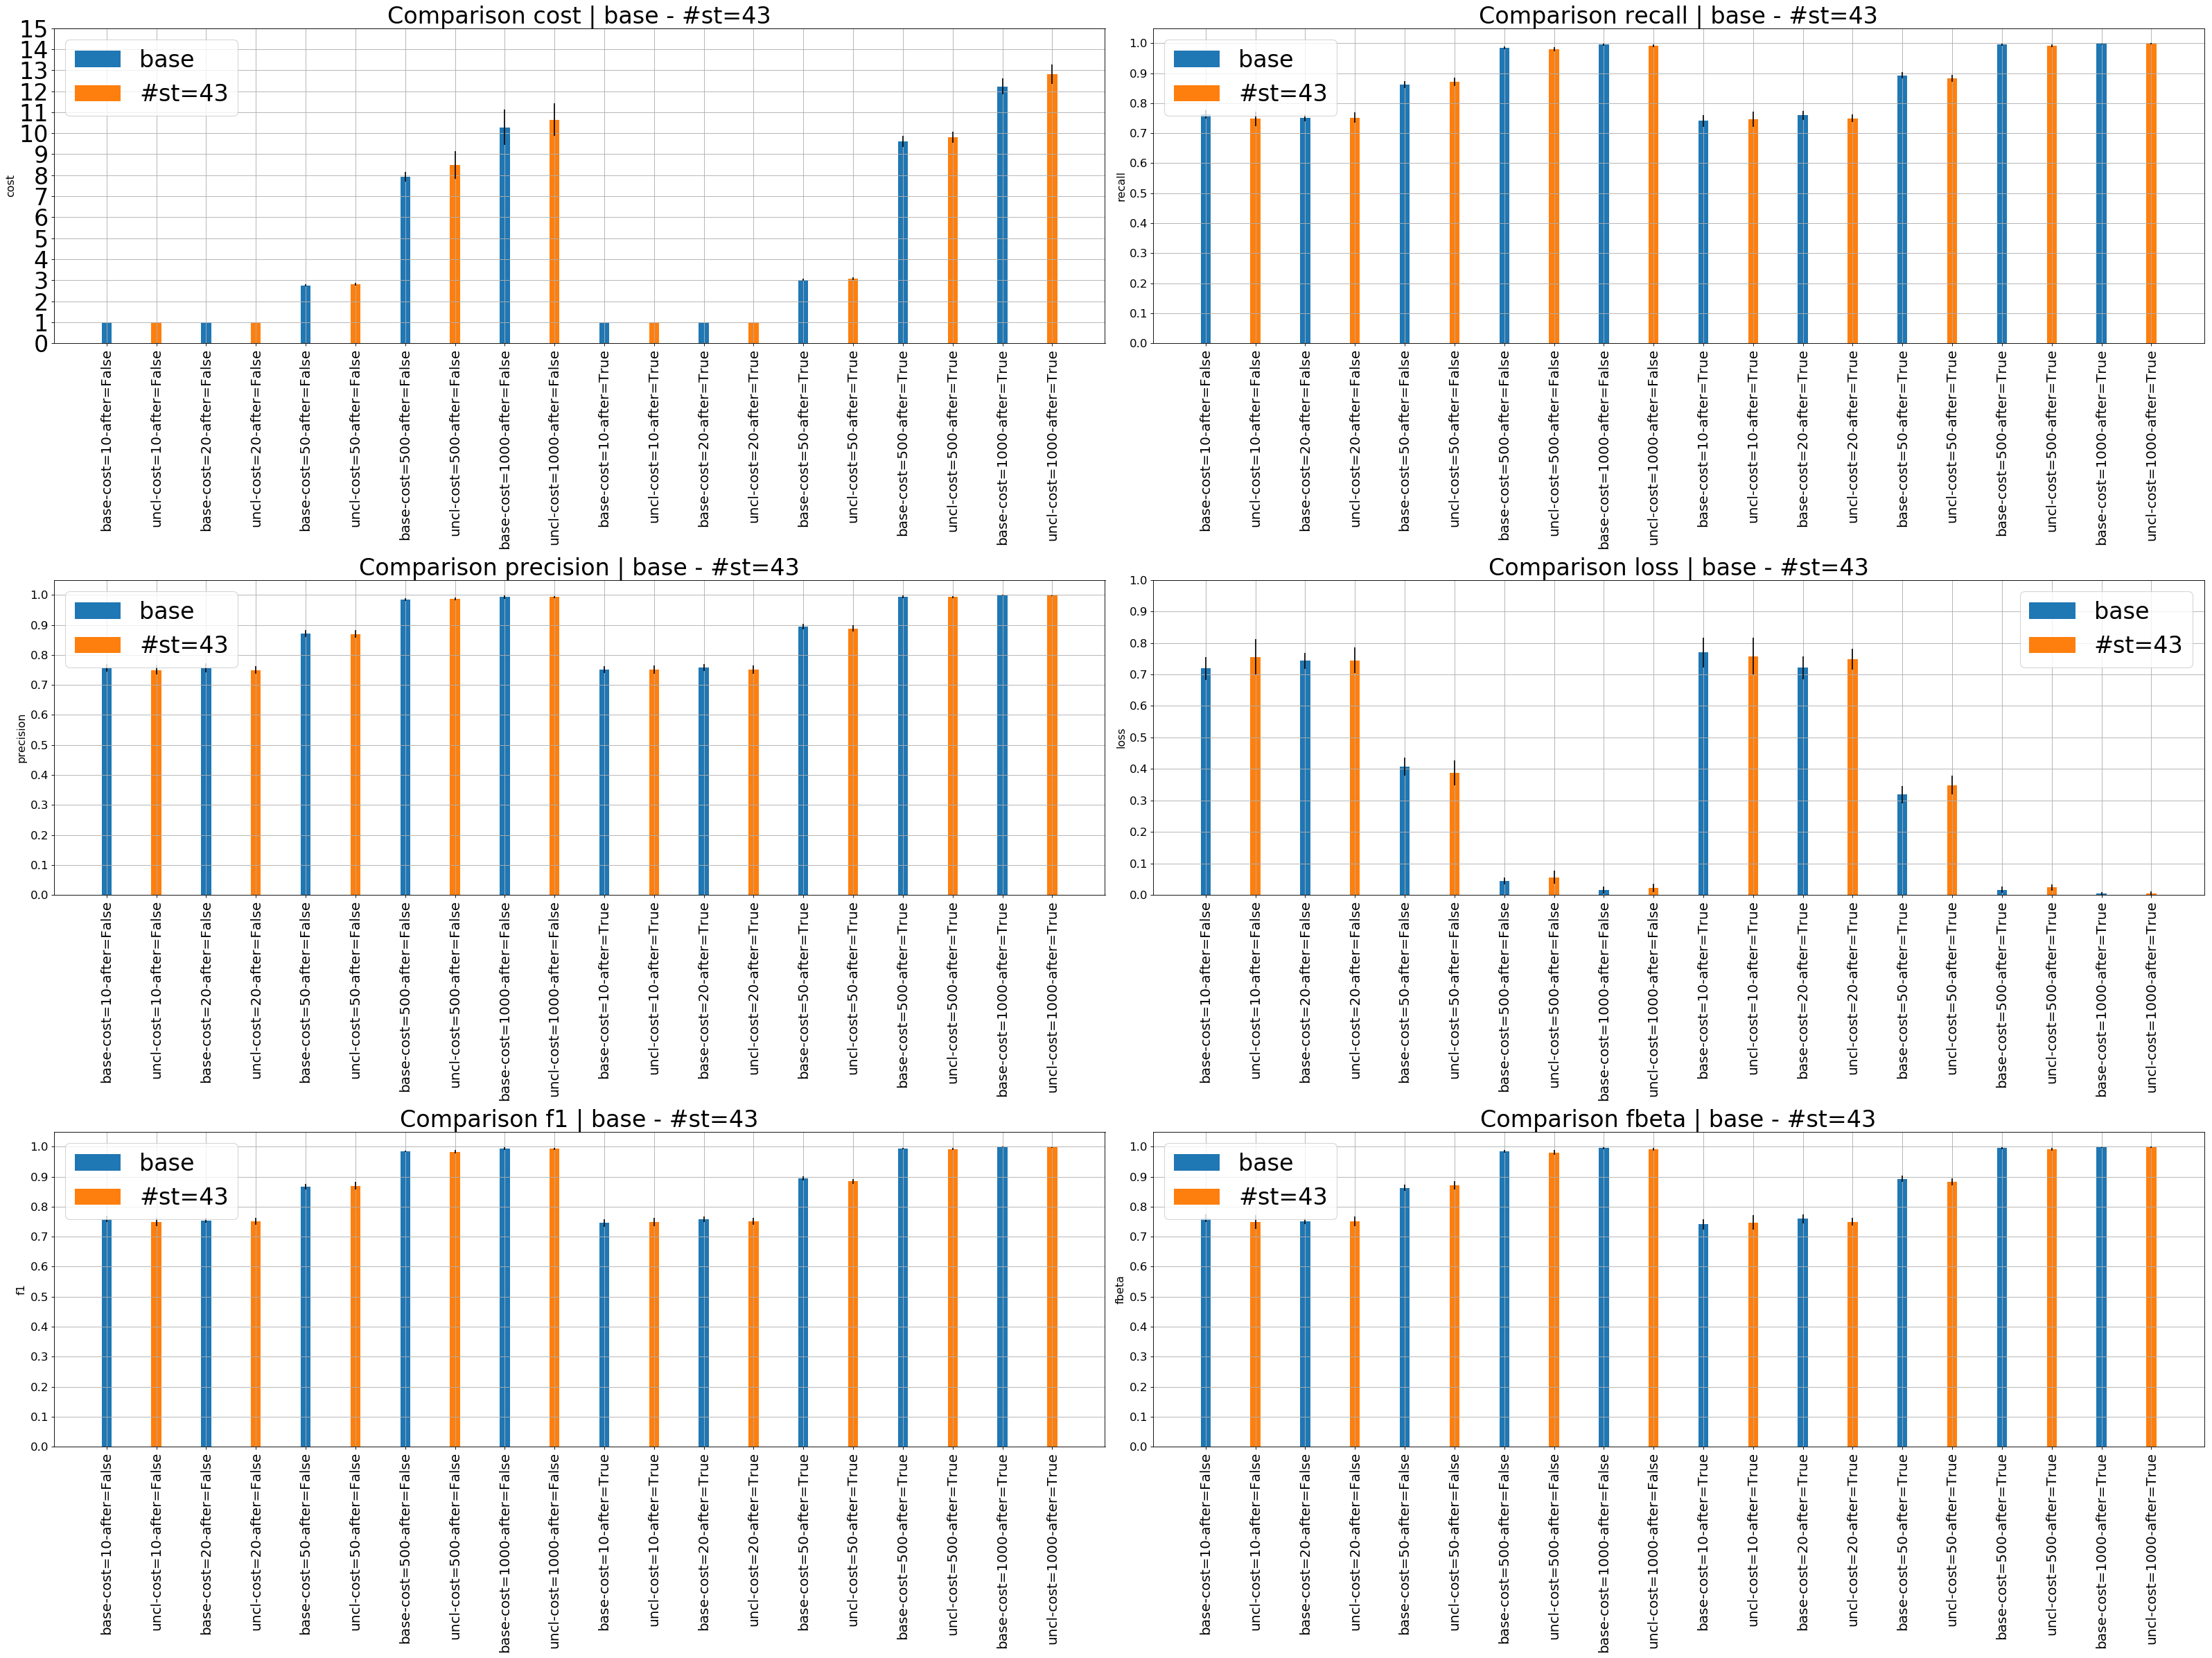

In [436]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')

elems_base = data[data.name.str.startswith('base-')]
total_elems = data[data.name.str.startswith('vary_num_states')]

num_states = total_elems.num_states.unique()

for num_st in num_states:
    print(" ")
    print("------------------------------------------------------------------------------------------")
    print(" ")
    print(f"Num States: {num_st}")
    print(" ")
    
    elems_st = total_elems[total_elems.num_states == num_st]

    columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

    #print(elems[['num_states', 'wrong_cost', 'estimate_after']+columns])

    #plot_elems(elems, columns)

    plot_elems_comparisson(elems_base, elems_st, 'base', f'#st={num_st}', columns)
    

### 2.1 Compare results for reward wrong answer = -500

     num_states  wrong_cost  estimate_after   cost  recall  precision   loss  \
13            5         500           False  1.000   0.752      0.748  0.746   
18            5         500            True  1.000   0.747      0.749  0.758   
23            9         500           False  6.975   0.976      0.973  0.074   
28            9         500            True  7.866   0.982      0.986  0.051   
33           13         500           False  7.568   0.981      0.982  0.055   
38           13         500            True  9.405   0.991      0.990  0.028   
43           17         500           False  7.874   0.979      0.982  0.062   
48           17         500            True  9.686   0.993      0.992  0.021   
3            23         500           False  7.925   0.985      0.985  0.044   
8            23         500            True  9.613   0.995      0.994  0.017   
103          43         500           False  8.484   0.980      0.987  0.056   
108          43         500            T

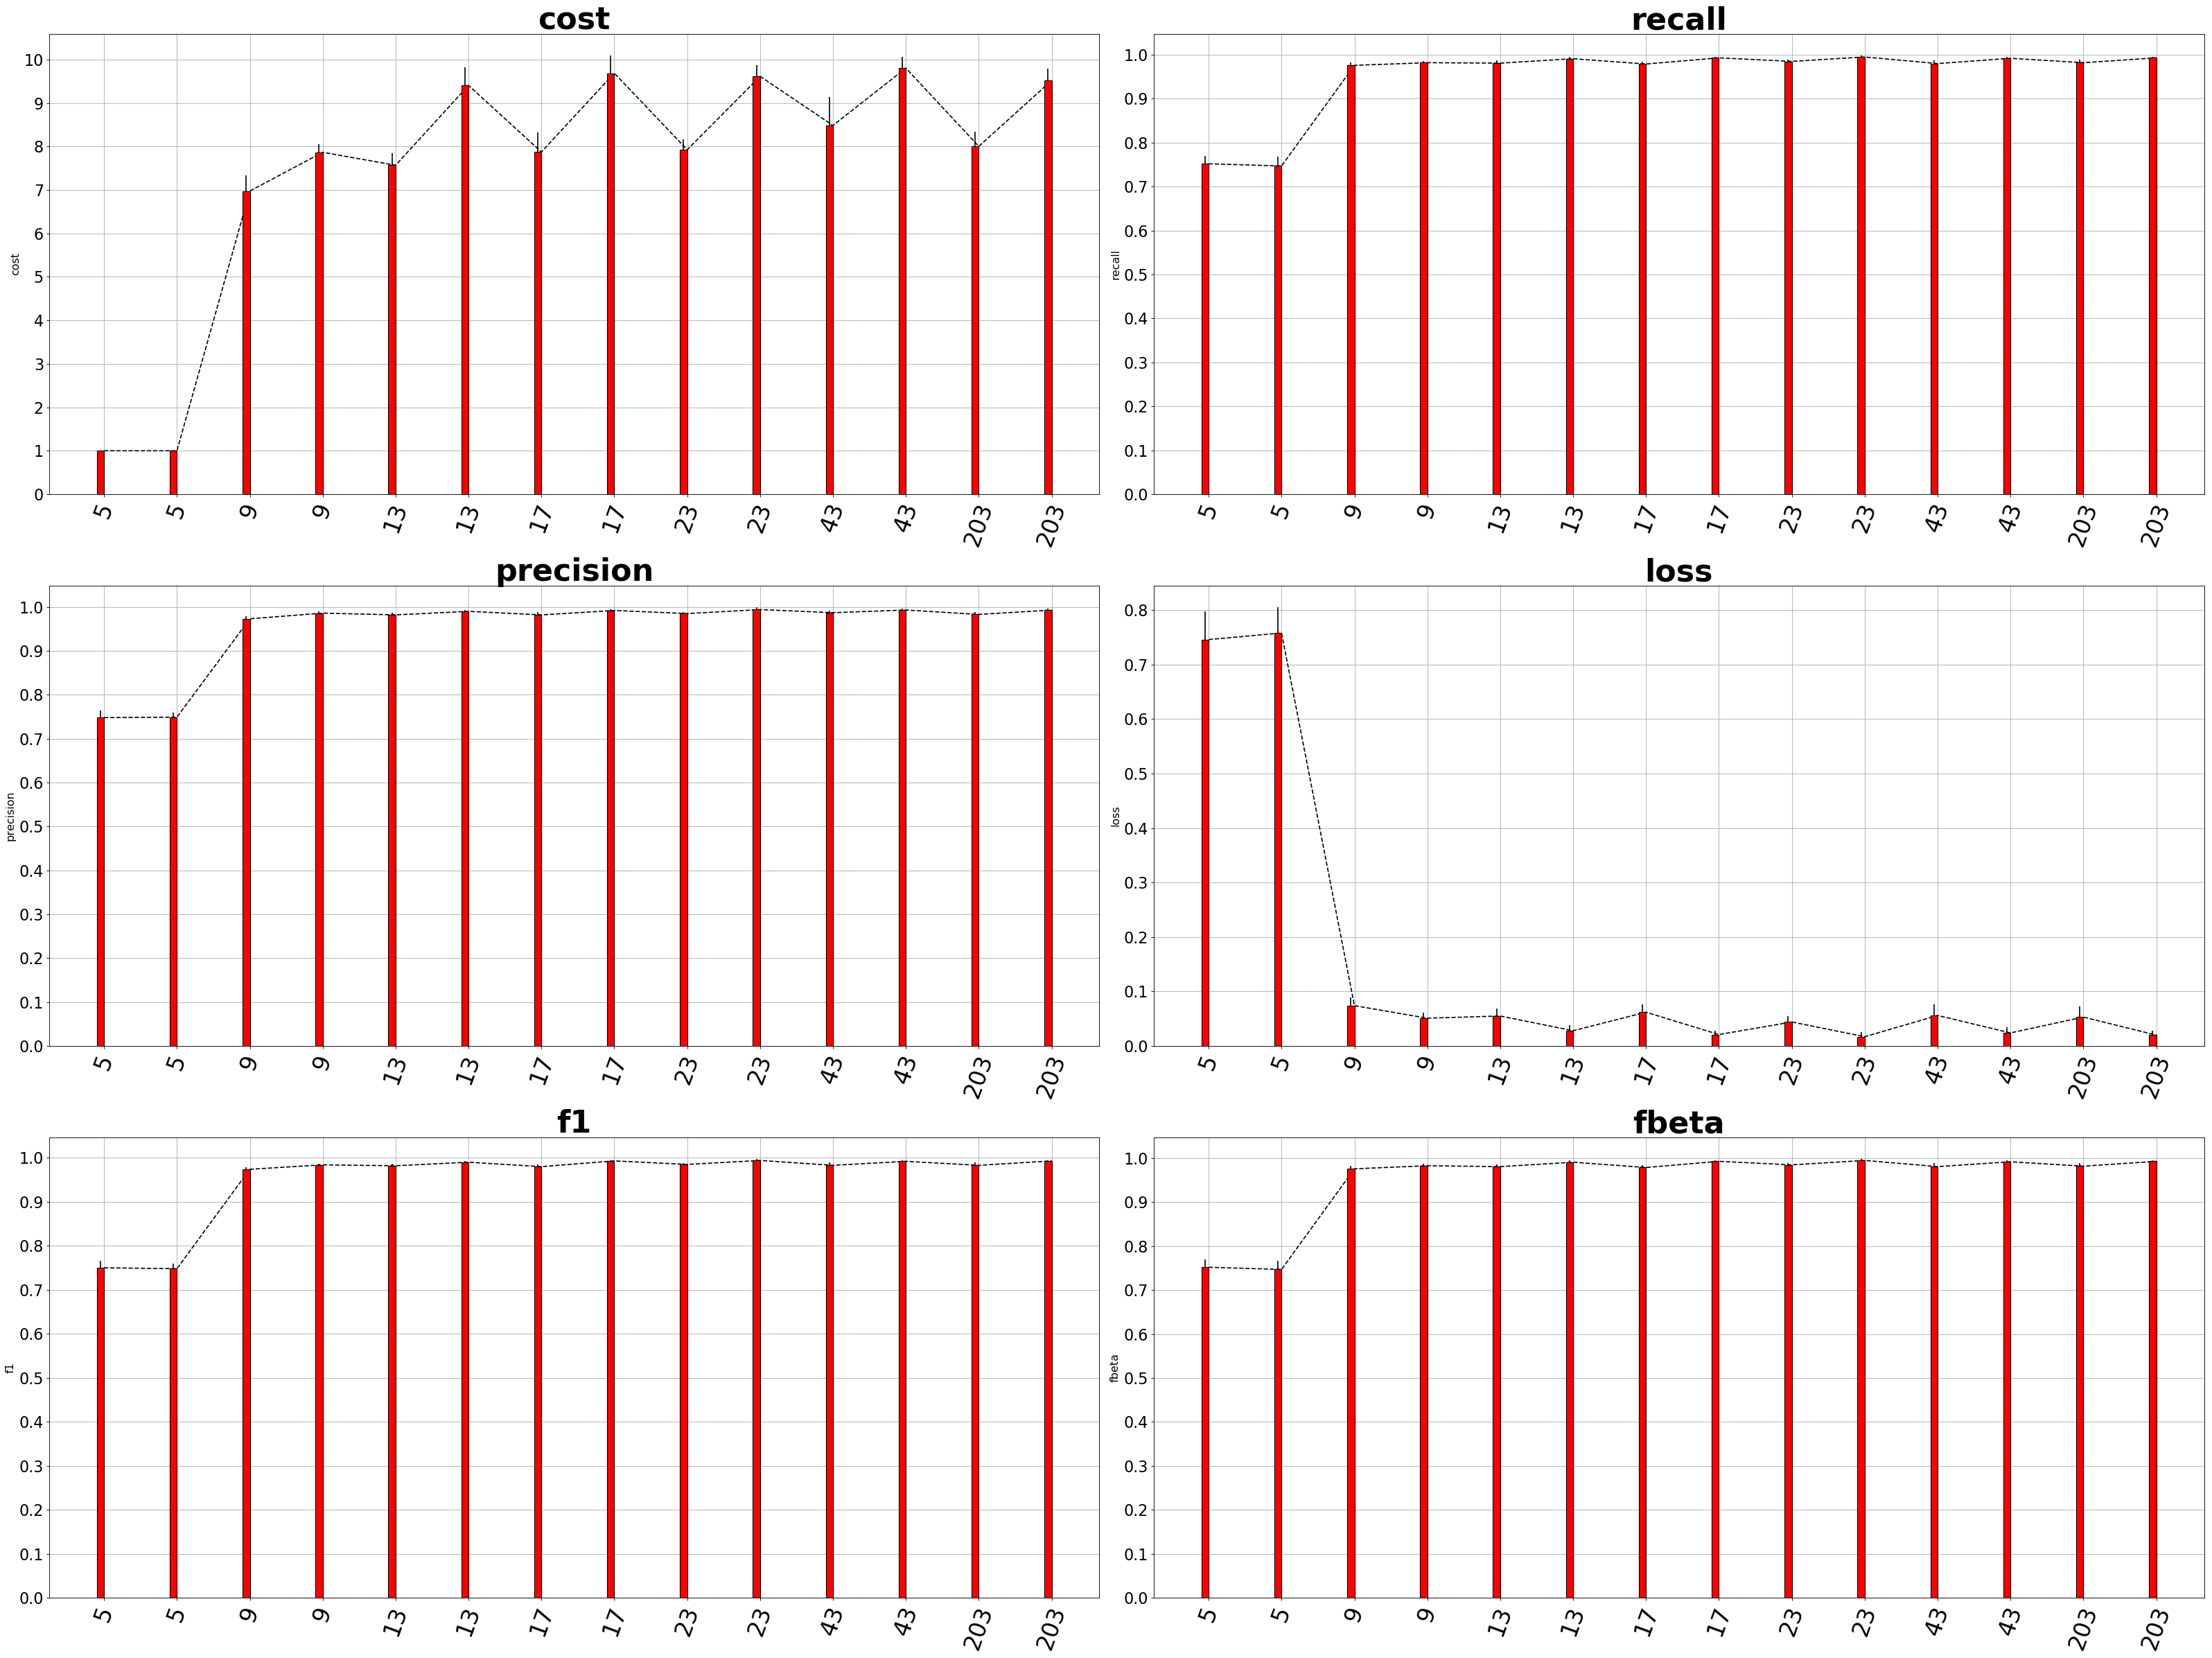

In [460]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')

elems_less = data[data.name.str.startswith('vary_num_states')][data['wrong_cost'] == 500][data['num_states'] < 23]
elems_base = data[data.name.str.startswith('base')][data['wrong_cost'] == 500]
elems_more = data[data.name.str.startswith('vary_num_states')][data['wrong_cost'] == 500][data['num_states'] > 23]

elems = pd.concat([elems_less, elems_base])
elems = pd.concat([elems, elems_more])

for elem in elems.iterrows():
    elem[1]['name'] = elems['num_states']
    
elems['name'] = np.where(True, elems['num_states'], elems['name'])

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['num_states', 'wrong_cost', 'estimate_after']+columns])

plot_elems(elems, columns)



#### Conclusions:
    - When varying the number of states, from 9 states and up the quality metrics are similar
    - From 13 states and up the money cost are similar 
    - With 5 states the representation of the world is bad and only 1 vote is collected before classifying the item

## 3. Try adding 1 the action of "leave item unclassified"

POMDP definition: 
 - States: 23
 - Actions: 4 = {RequestVote, SubmitFalse, SubmitTrue, LeaveUnclassified}
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 - $T(S_i, Action=LeaveUnclassified, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: -500
 - Leave Unclassified: -5

Workers:
 - Amount: 100
 - Error rate distribution: $\gamma \sim Normal(1, 0.2)$


                     name  estimate_after    cost  recall  precision   loss  \
77      unclassify-c10-u5           False   1.000   0.558      0.562  1.322   
78     unclassify-c20-u10           False   1.000   0.558      0.563  1.321   
79     unclassify-c50-u20           False   2.864   0.616      0.601  1.165   
80   unclassify-c500-u200           False  10.561   0.686      0.696  0.936   
81  unclassify-c1000-u500           False  14.536   0.728      0.721  0.821   
82      unclassify-c10-u5            True   1.000   0.569      0.567  1.294   
83     unclassify-c20-u10            True   1.000   0.562      0.565  1.312   
84     unclassify-c50-u20            True   3.418   0.628      0.625  1.119   
85   unclassify-c500-u200            True  14.109   0.720      0.725  0.836   
86  unclassify-c1000-u500            True  19.292   0.752      0.756  0.742   

       f1  fbeta  
77  0.560  0.559  
78  0.561  0.558  
79  0.608  0.615  
80  0.691  0.686  
81  0.724  0.728  
82  0.568  0.569

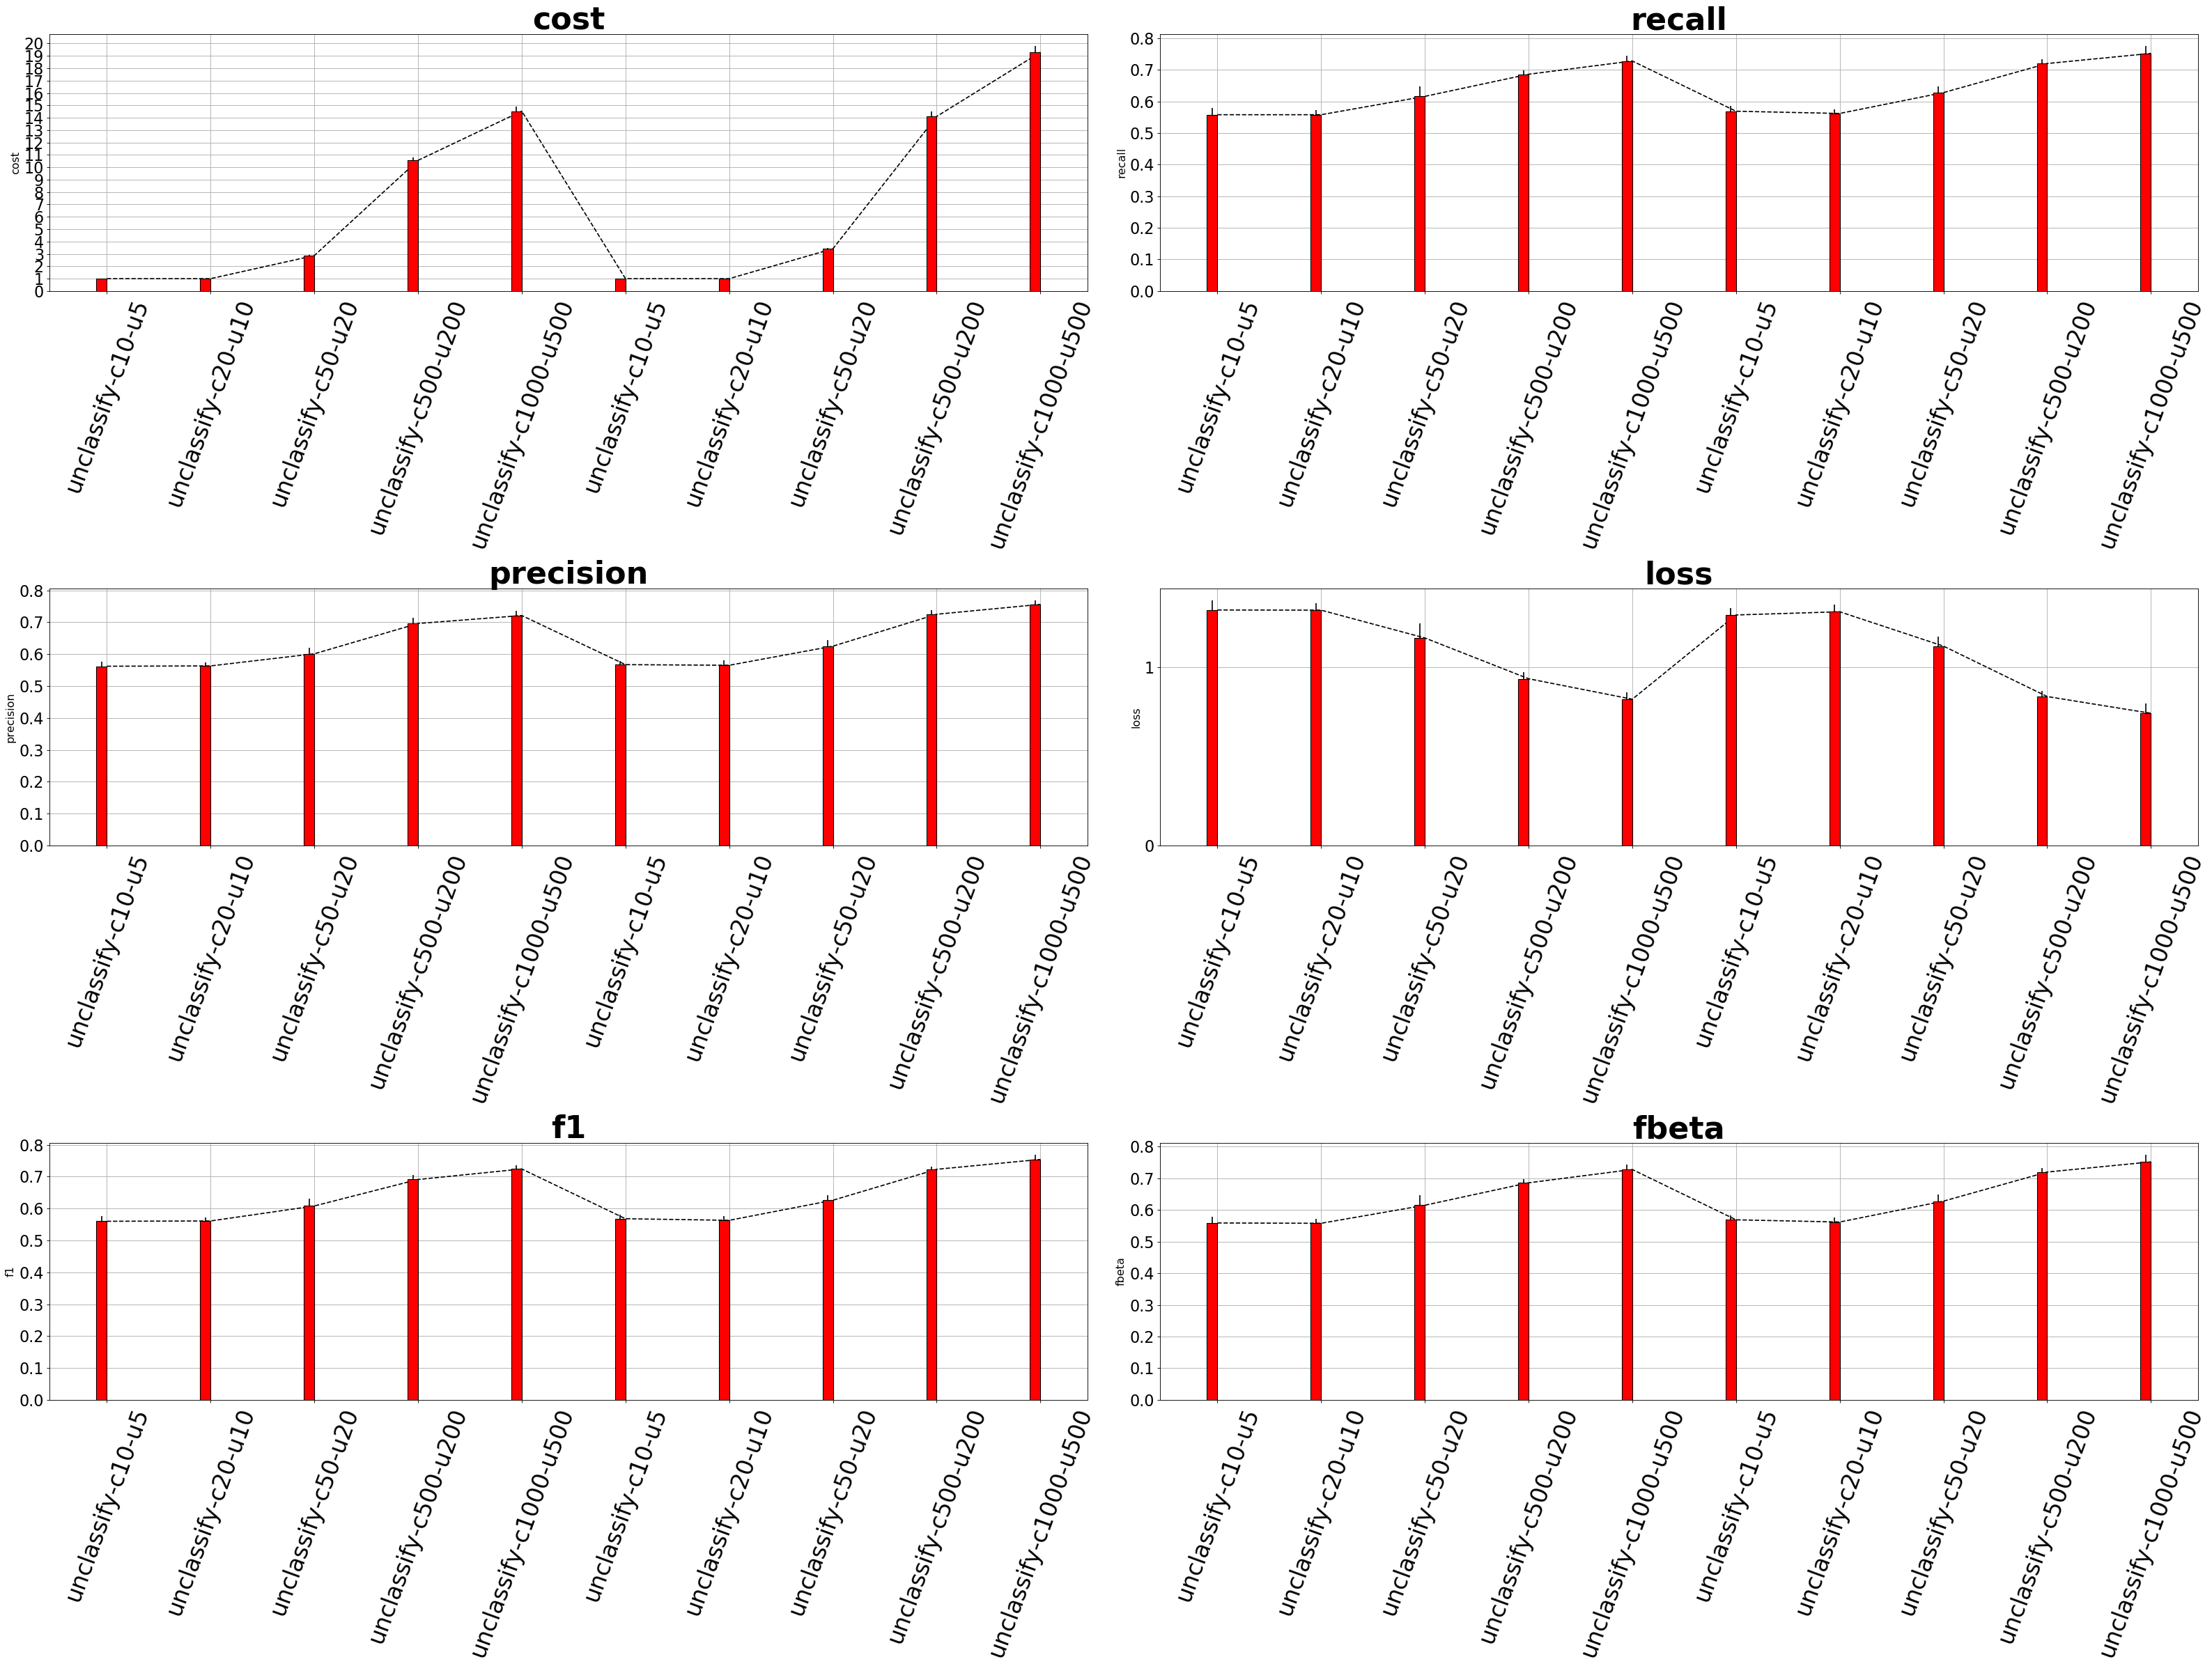

In [406]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('unclassify-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

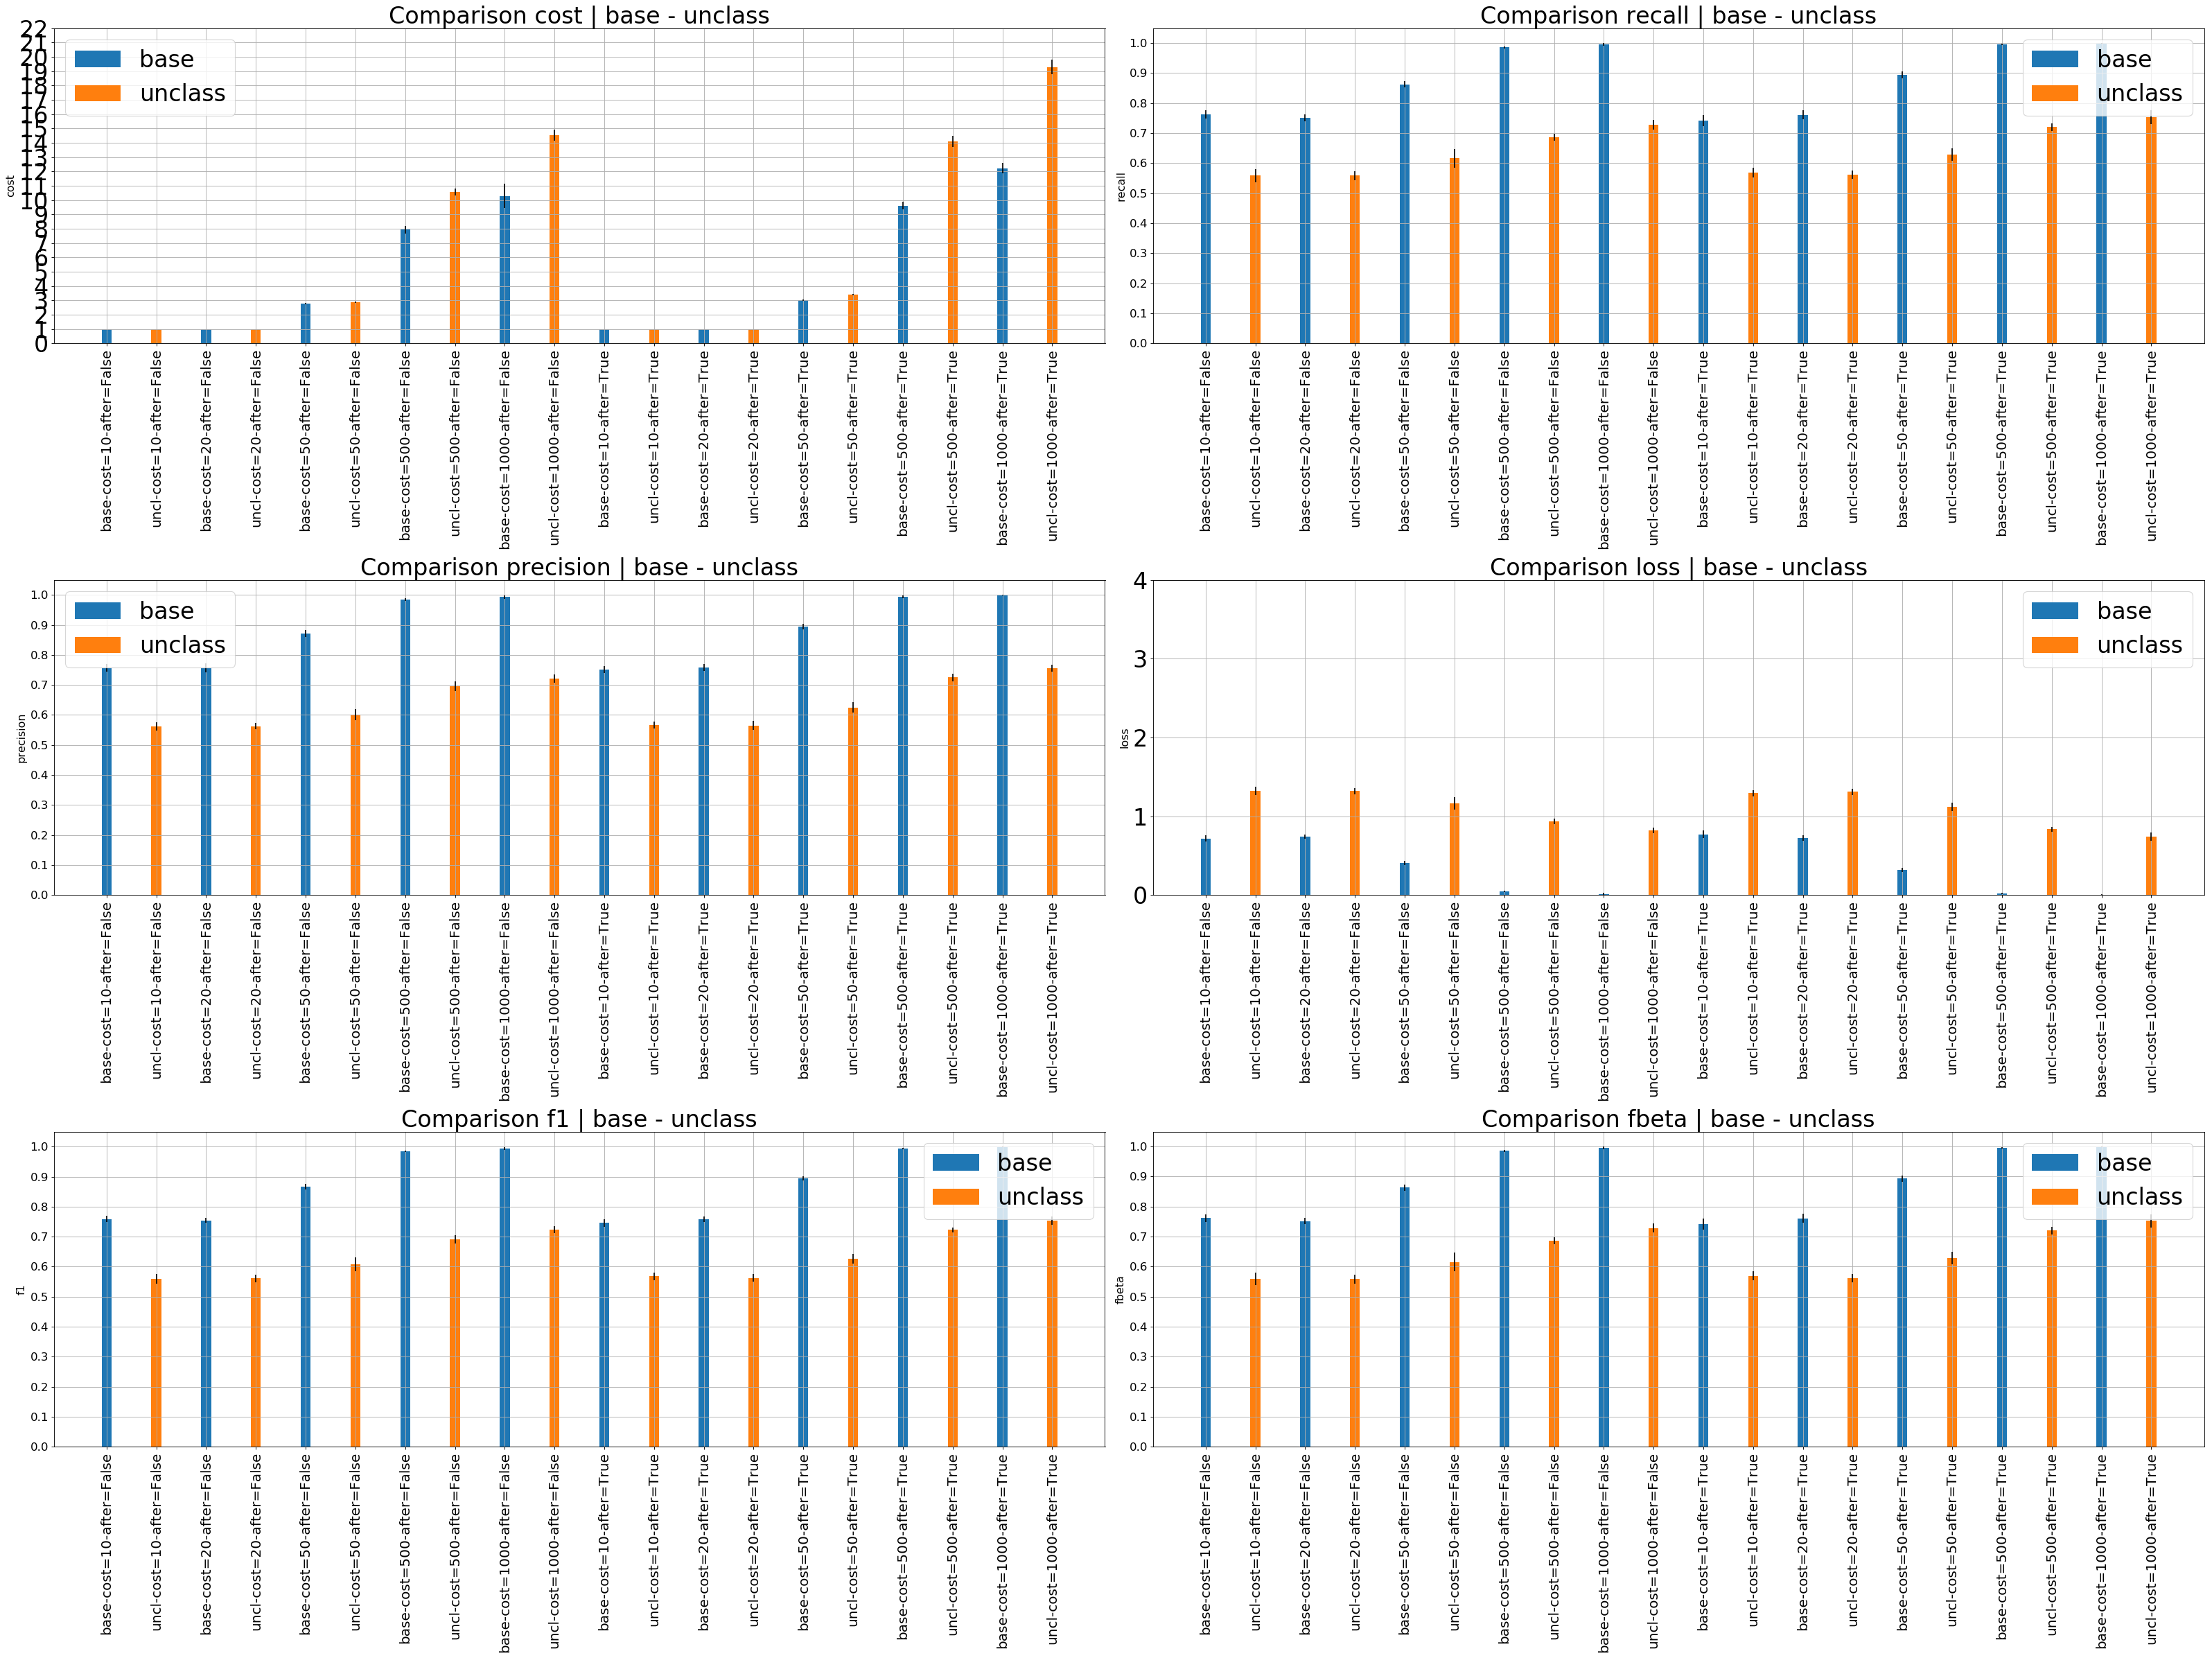

In [453]:
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')

elems_base = data[data.name.str.startswith('base-')]
elems_unc = data[data.name.str.startswith('unclassify-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

plot_elems_comparisson(elems_base, elems_unc, 'base', 'unclass', columns)

#### Conclusions:
    - Adding the action "leave item unclassify" dont improve results, increments costs and quality is lower than base
    

## 4. Try with different real error rate distribution

POMDP definition: 
 - States: 23
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: {-10, -20, -50, -500, -1000}

Workers:
 - Amount: 100

### 4.1 Worker error rate distribution: Bimodal
 - 50%: $\gamma \sim Normal(.2, 0.01)$
 - 50%: $\gamma \sim Normal(4, 0.2)$ 

             name  estimate_after   cost  recall  precision   loss     f1  \
50    bimodal-c10           False  1.000   0.738      0.738  0.787  0.738   
51    bimodal-c20           False  1.000   0.746      0.733  0.770  0.740   
52    bimodal-c50           False  2.687   0.873      0.878  0.378  0.875   
53   bimodal-c500           False  5.858   0.985      0.985  0.045  0.985   
54  bimodal-c1000           False  6.668   0.993      0.992  0.022  0.992   
55    bimodal-c10            True  1.000   0.737      0.736  0.791  0.736   
56    bimodal-c20            True  1.000   0.730      0.728  0.811  0.729   
57    bimodal-c50            True  3.043   0.889      0.892  0.332  0.890   
58   bimodal-c500            True  8.294   0.991      0.992  0.026  0.992   
59  bimodal-c1000            True  9.799   0.996      0.993  0.013  0.995   

    fbeta  
50  0.738  
51  0.746  
52  0.873  
53  0.985  
54  0.993  
55  0.737  
56  0.730  
57  0.889  
58  0.991  
59  0.996  


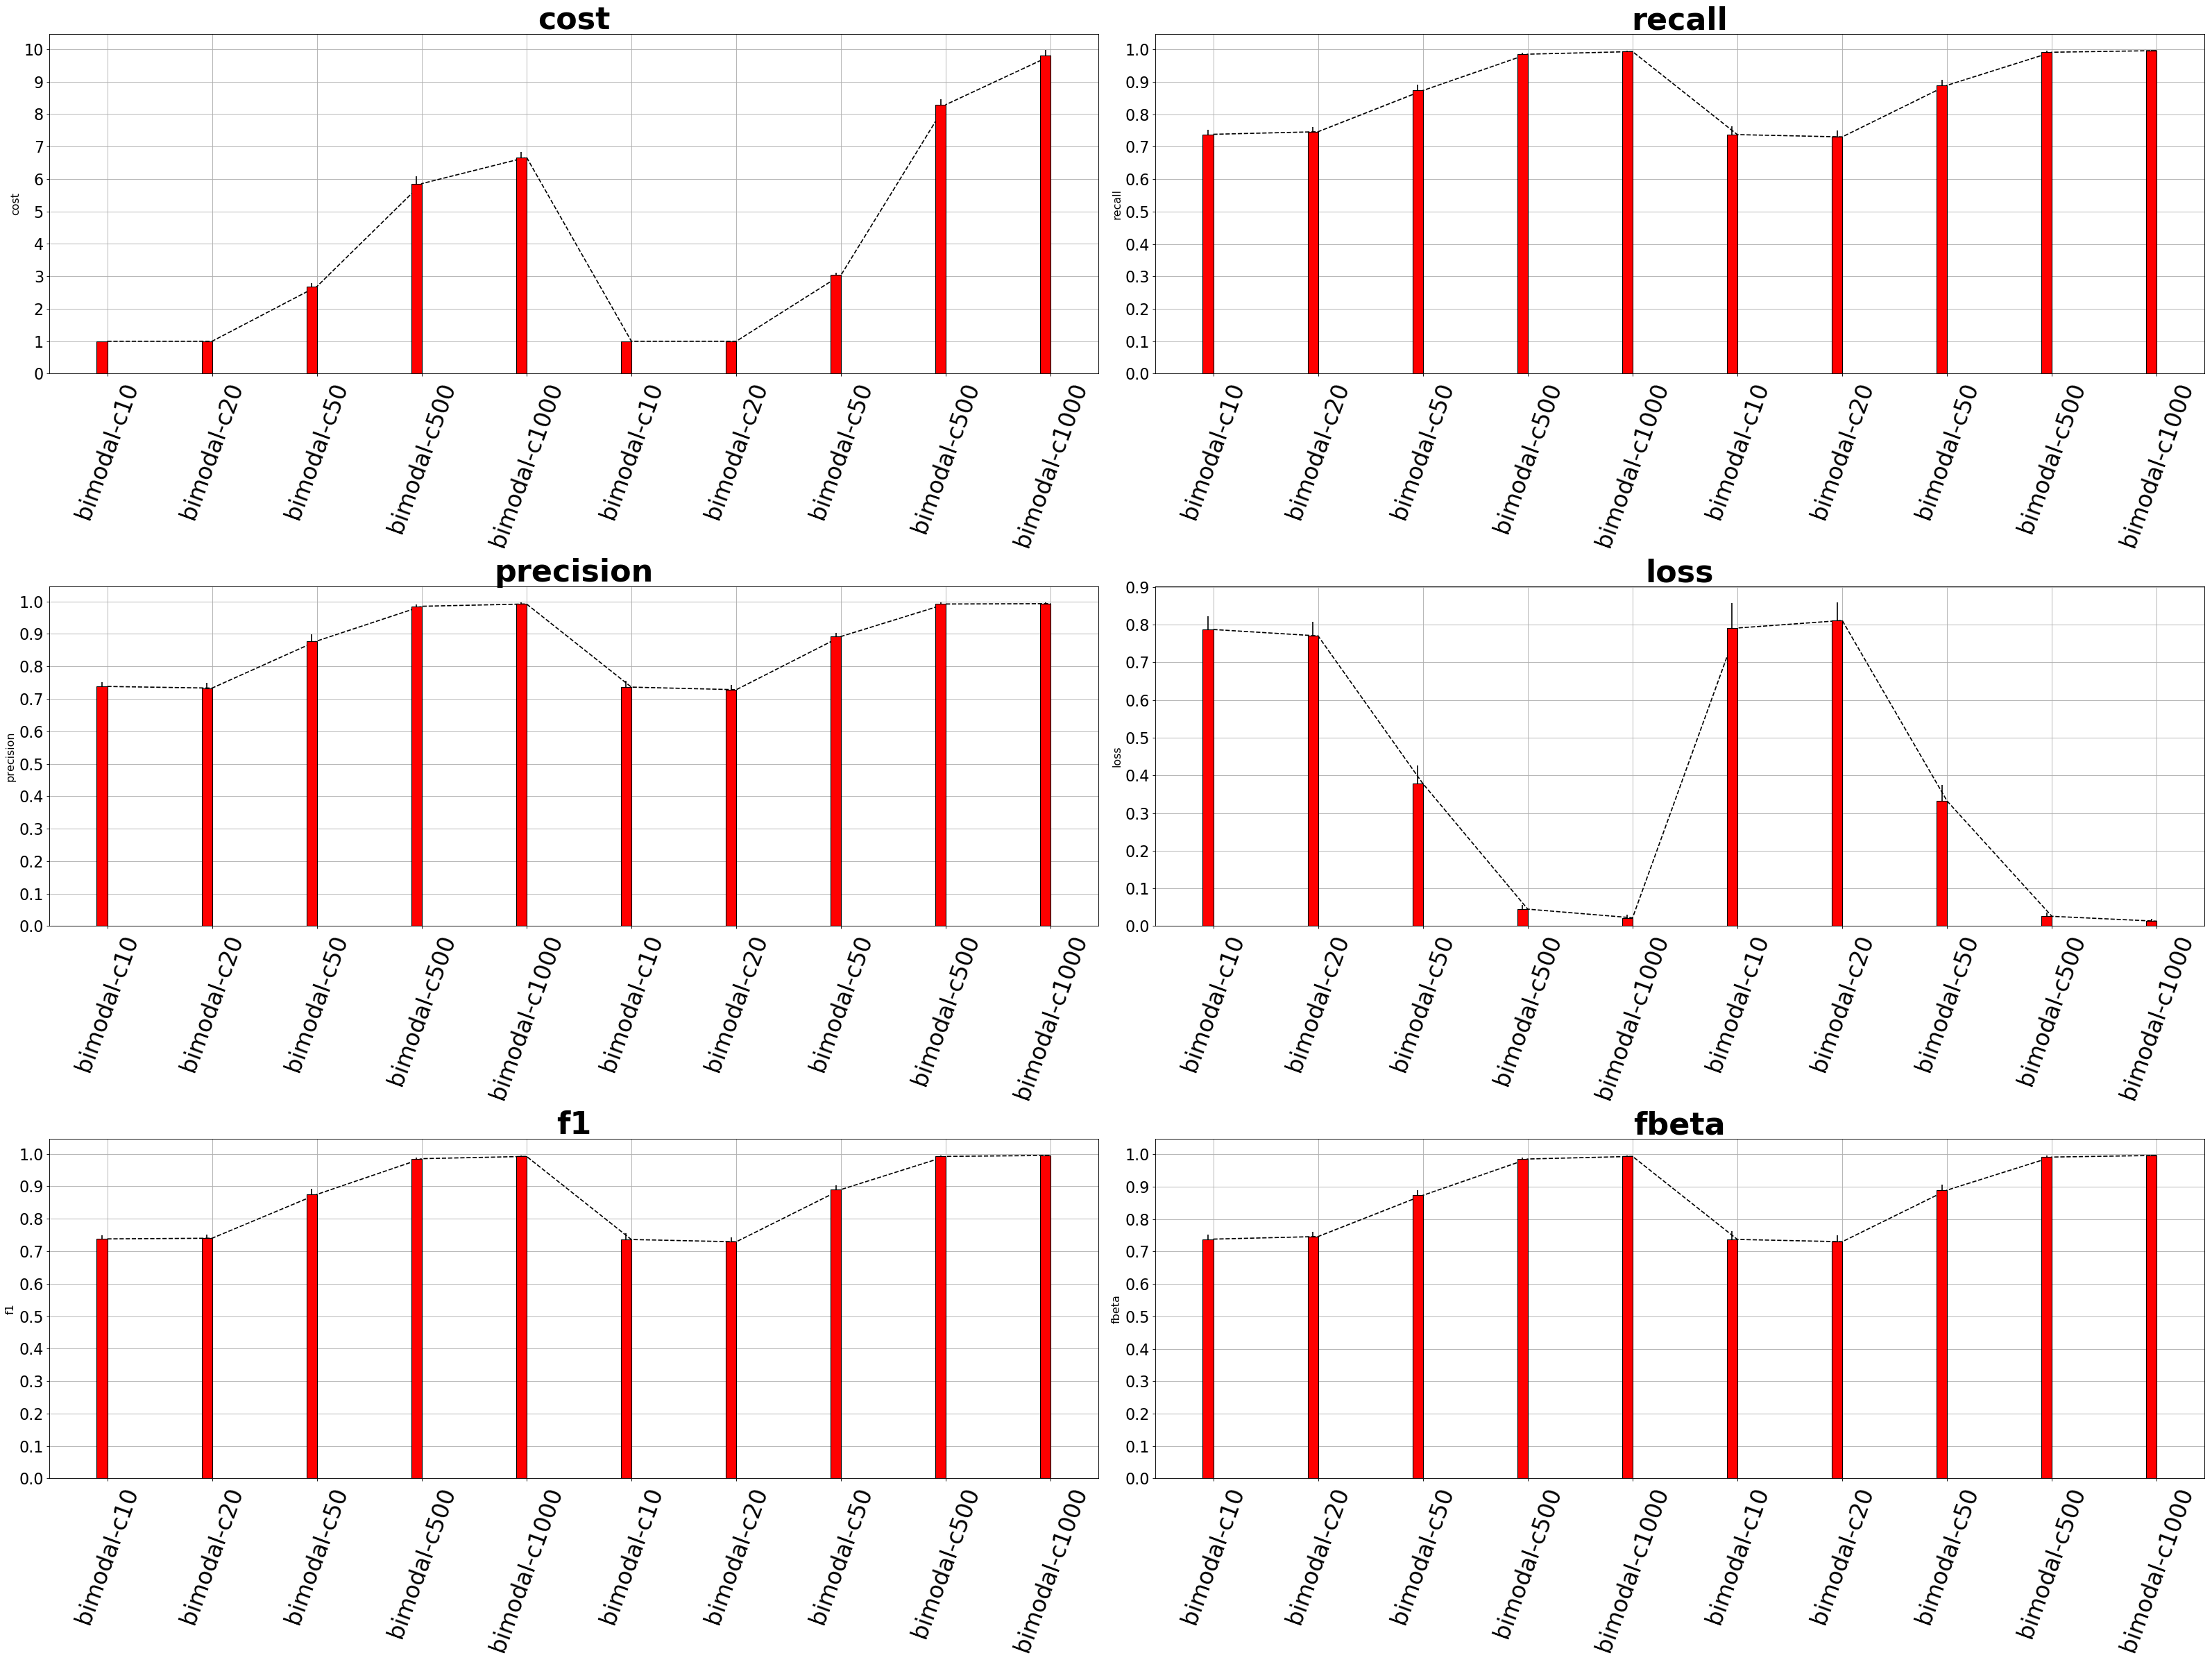

In [407]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('bimodal')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

### 4.2 Worker error rate distribution (good workers - low error): $\gamma \sim Normal(1, 0.2)$ 

- 100%: $\gamma \sim Normal(0.2, 0.01)$

          name  estimate_after   cost  recall  precision   loss     f1  fbeta
60    good-c10           False  1.000   0.935      0.931  0.197  0.933  0.935
61    good-c20           False  1.000   0.935      0.937  0.195  0.936  0.935
62    good-c50           False  2.121   0.979      0.985  0.060  0.982  0.979
63   good-c500           False  3.102   0.999      0.997  0.003  0.998  0.999
64  good-c1000           False  3.680   0.999      0.999  0.004  0.999  0.999
65    good-c10            True  1.000   0.939      0.937  0.185  0.938  0.939
66    good-c20            True  1.000   0.940      0.939  0.180  0.940  0.940
67    good-c50            True  2.243   0.993      0.992  0.021  0.993  0.993
68   good-c500            True  5.641   1.000      1.000  0.001  1.000  1.000
69  good-c1000            True  6.773   1.000      1.000  0.000  1.000  1.000


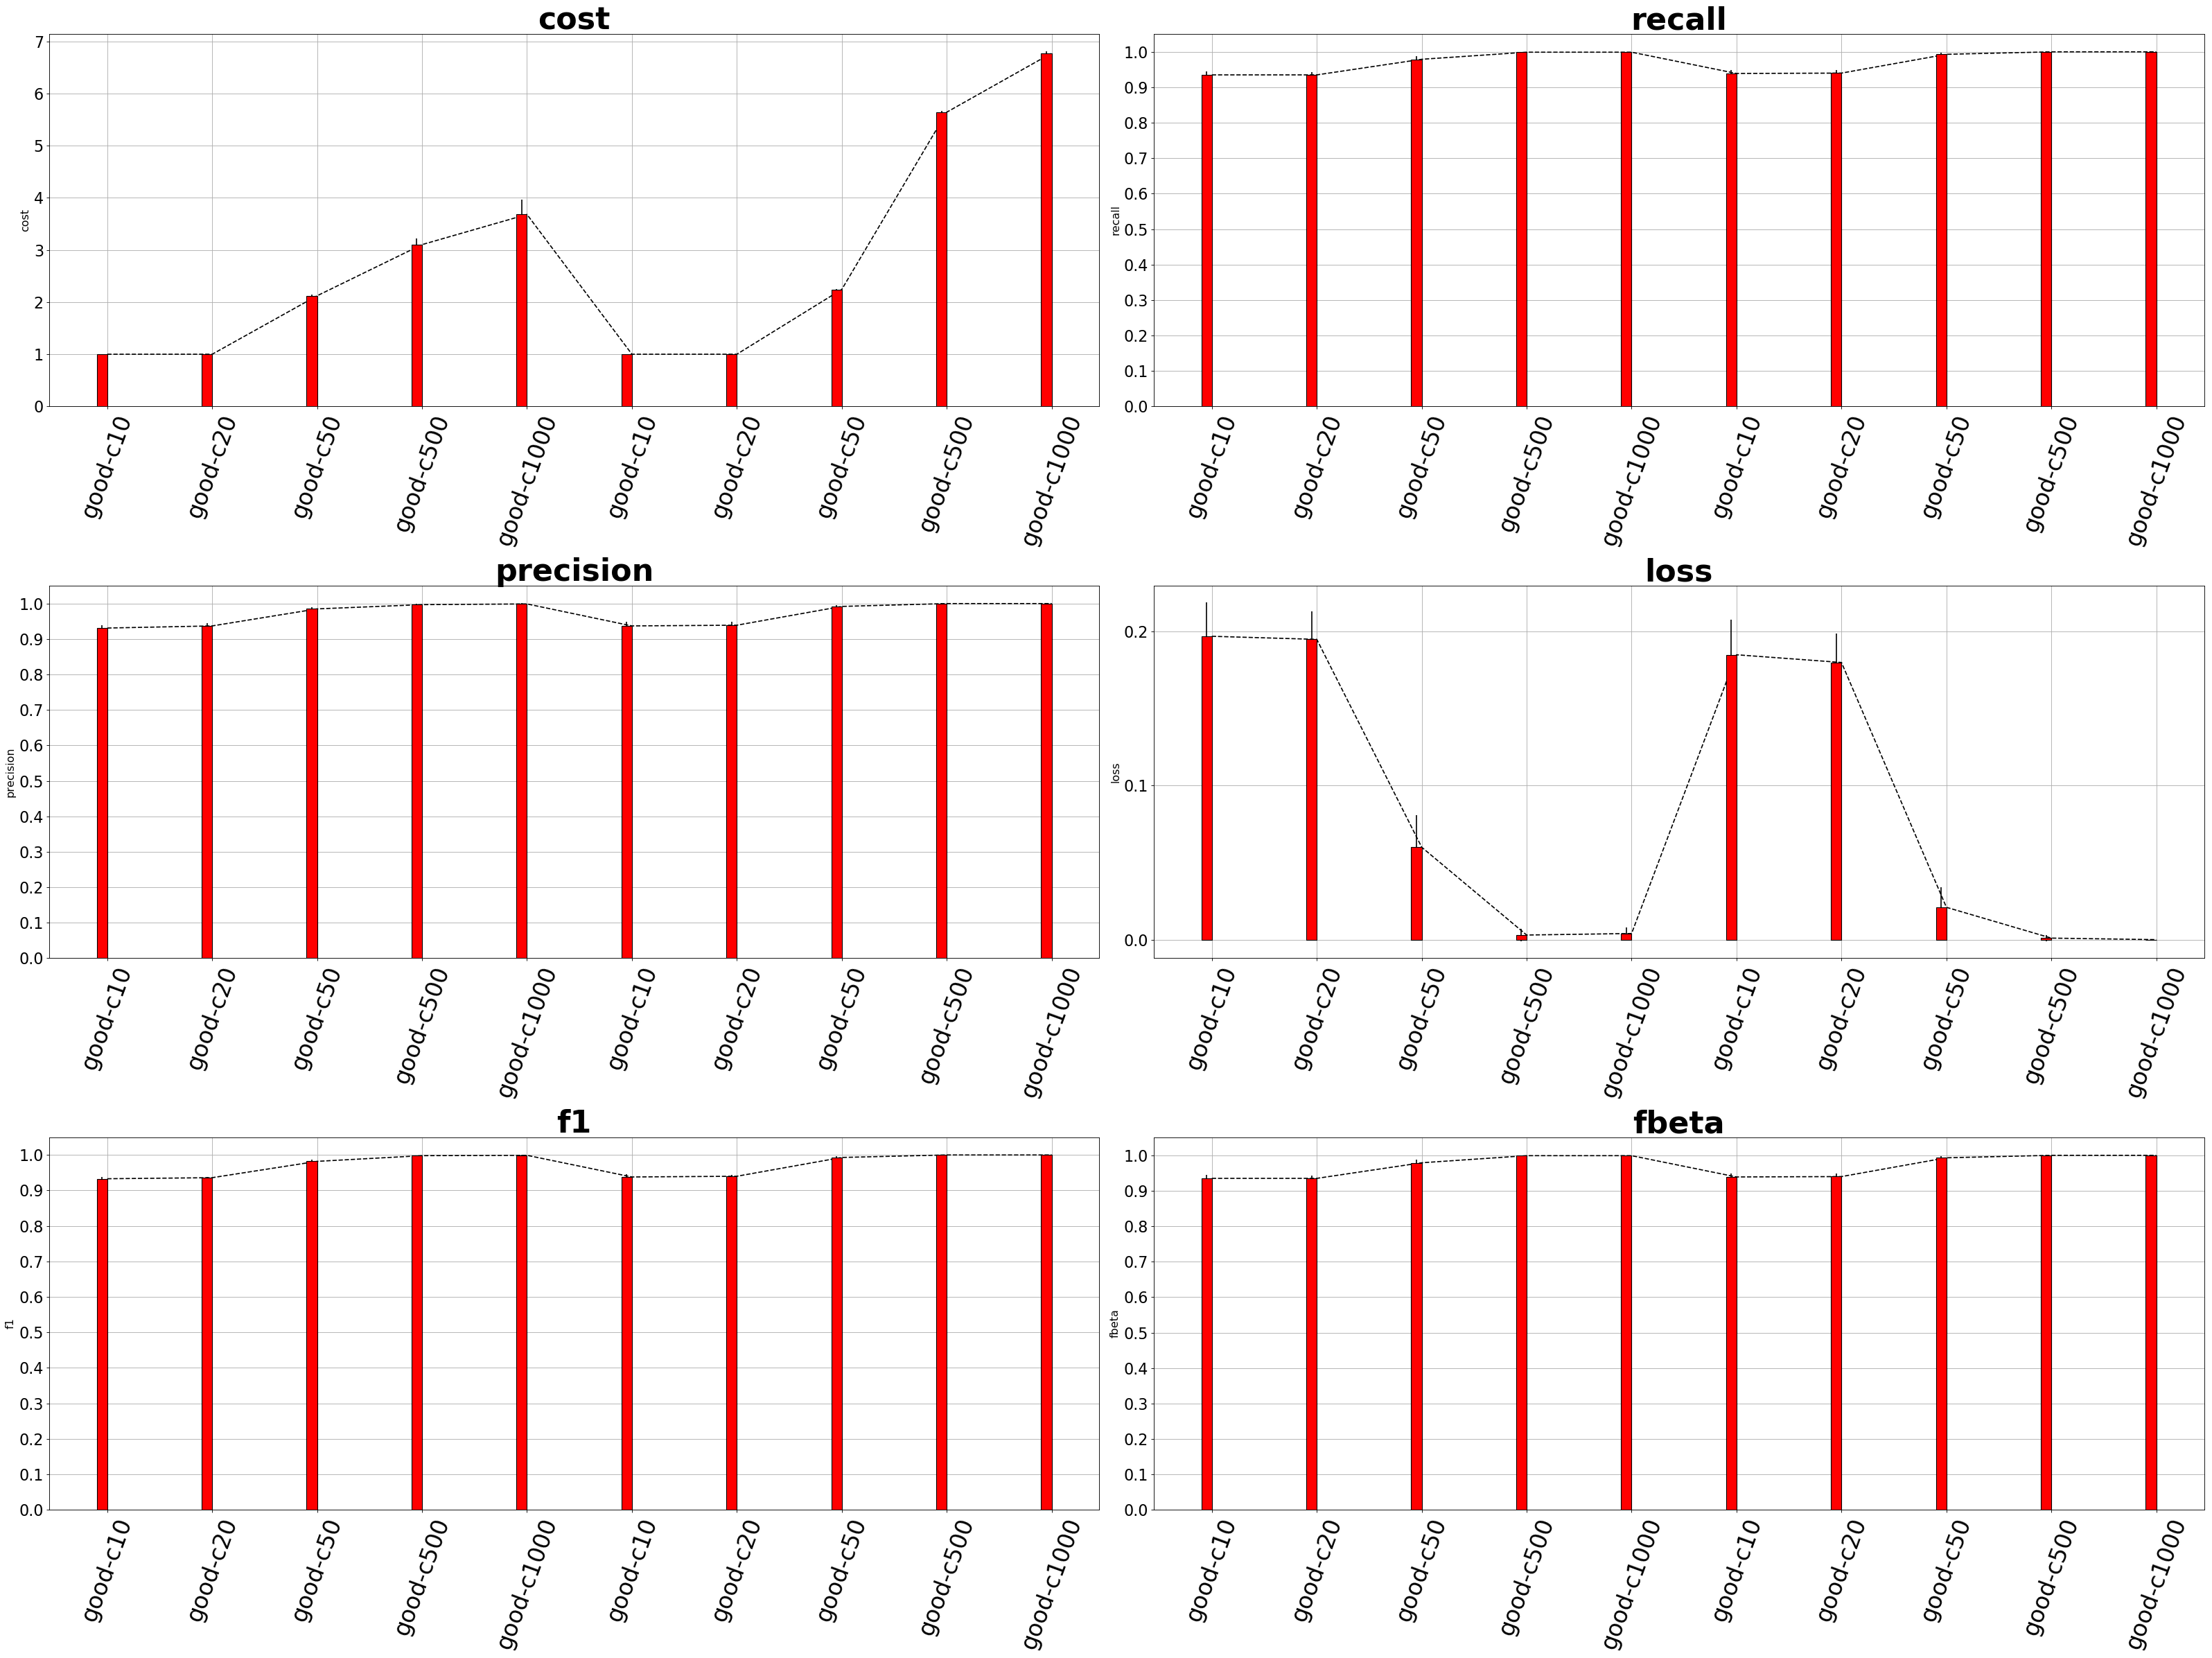

In [408]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('good')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)


### 4.3 Worker error rate distribution (bad workers - high error):  $\gamma \sim Normal(4, 0.2)$ 
- 100%: $\gamma \sim Normal(4, 0.2)$

         name  estimate_after    cost  recall  precision   loss     f1  fbeta
70    bad-c10           False   1.000   0.573      0.567  1.285  0.570  0.573
71    bad-c20           False   1.000   0.559      0.564  1.318  0.561  0.560
72    bad-c50           False   3.311   0.602      0.598  1.197  0.600  0.602
73   bad-c500           False  10.872   0.686      0.695  0.936  0.690  0.686
74  bad-c1000           False  14.876   0.726      0.726  0.821  0.726  0.726
75    bad-c10            True   1.000   0.567      0.566  1.301  0.566  0.567
76    bad-c20            True   1.000   0.566      0.556  1.311  0.561  0.565
77    bad-c50            True   3.391   0.614      0.612  1.160  0.613  0.614
78   bad-c500            True  14.250   0.709      0.716  0.869  0.712  0.709
79  bad-c1000            True  20.005   0.748      0.749  0.756  0.748  0.748


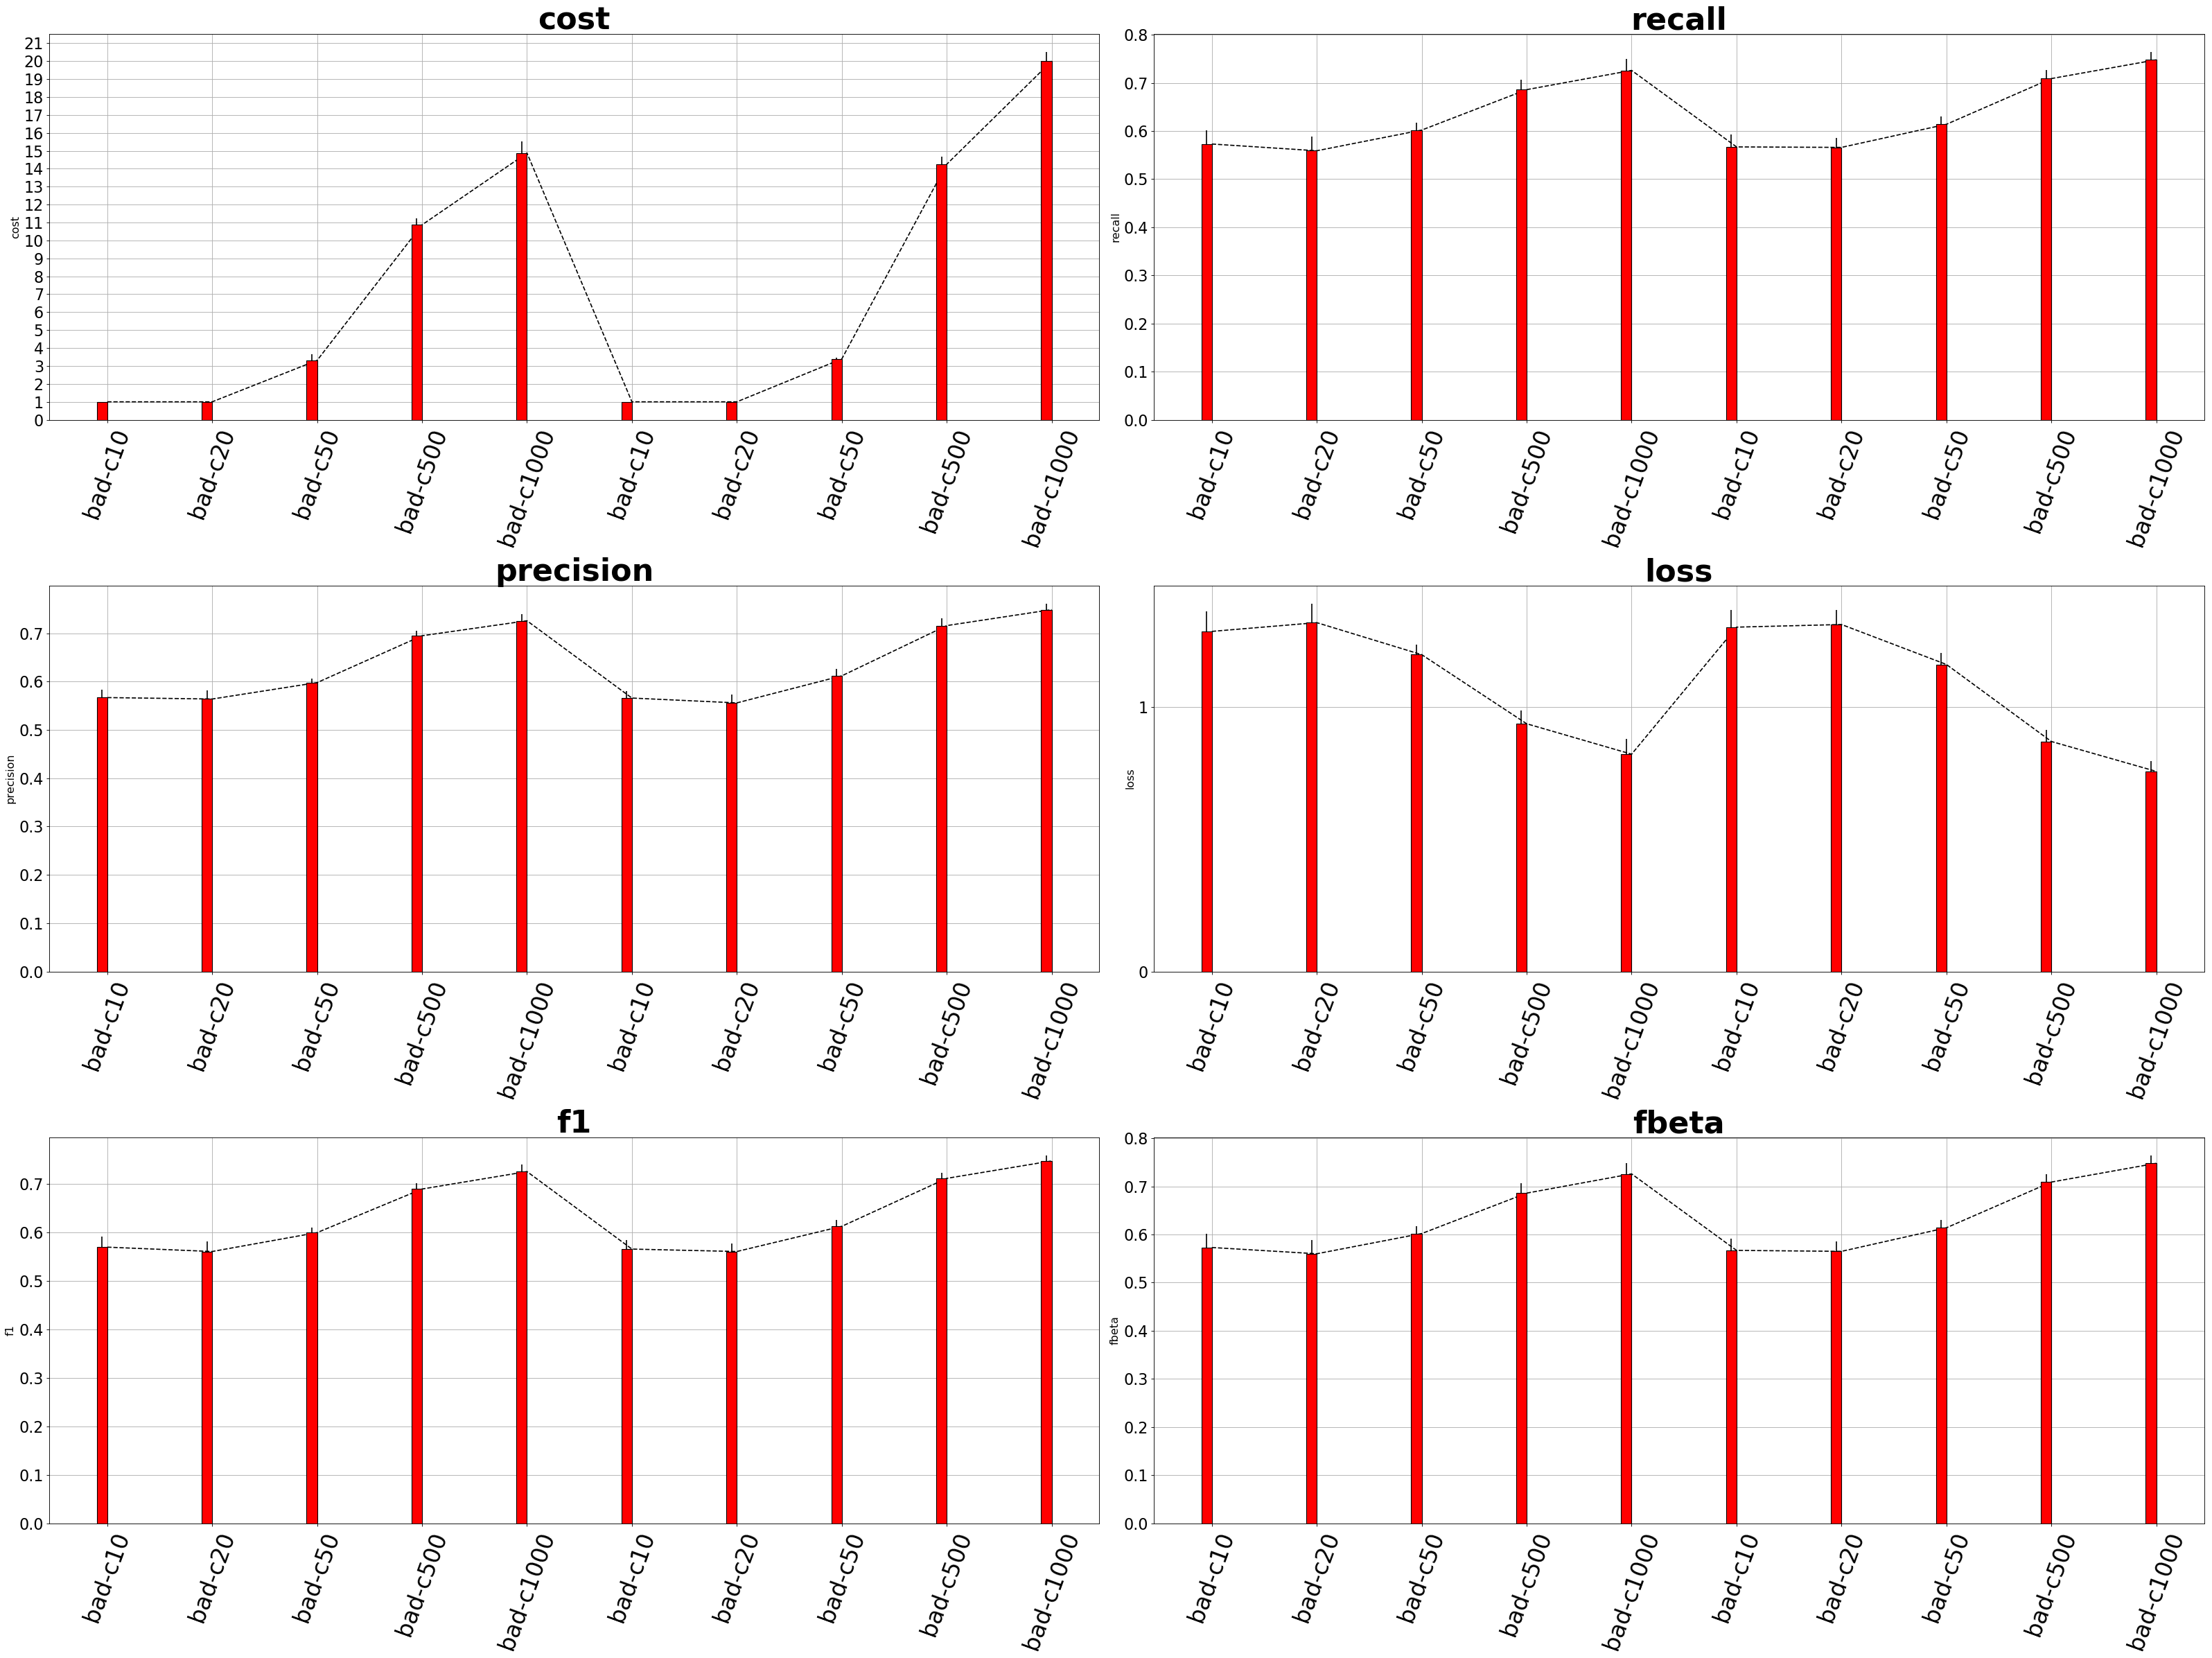

In [411]:
from IPython.core import display as ICD

data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('bad')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

#### Conclusions:
    - The approach is sensitive to workers accuracy
    - When accuracy is lower it requests more votes but the quality is not leveraged proportionally
    

## 5. Workers error rate with a confusion matrix
- a worker error rate for possitive label class
- a higher worker error rate for negative label class



POMDP definition: 
 - States: 23
 
 Transitions: 
 - $T(S_i, Action=RequestVote, S_i) = 1$
 - $T(S_i, Action=SubmitTrue, S_{terminal}) = 1$
 - $T(S_i, Action=SubmitFalse, S_{terminal}) = 1$
 
 Observations probabilities:
 - $O(S_i, RequestVote, CorrectAnswer) = Acc$
 - $O(S_i, RequestVote, IncorrectAnswer) = 1 - Acc$
 
 Worker Accuracy Formula:
 - $Acc(d, \gamma) = \frac{1}{2} (1 + (1 - d)^{\gamma}) $
 
 Rewards:
 - Request vote: -1
 - Correct answer: 0
 - Wrong answer: {-10, -20, -50, -500, -1000}

Workers:
 - Amount: 100

Confusion Matrix:
 - Exclusion Error: $\gamma \sim Normal(1, 0.2)$
 - Inclusion Error: $\gamma \sim Normal(2, 0.2)$ 

Estimate after 2 votes
                      name  estimate_after   cost  recall  precision   loss  \
90    confusion-matrix-c10           False  1.000   0.748      0.845  0.699   
91    confusion-matrix-c20           False  1.000   0.758      0.836  0.679   
92    confusion-matrix-c50           False  2.476   0.858      0.947  0.380   
93   confusion-matrix-c500           False  5.273   0.965      0.996  0.089   
94  confusion-matrix-c1000           False  6.493   0.983      0.998  0.043   
95    confusion-matrix-c10            True  1.000   0.752      0.838  0.692   
96    confusion-matrix-c20            True  1.000   0.760      0.836  0.674   
97    confusion-matrix-c50            True  2.790   0.886      0.957  0.305   
98   confusion-matrix-c500            True  7.689   0.988      0.999  0.030   
99  confusion-matrix-c1000            True  9.447   0.995      1.000  0.012   

       f1  fbeta  
90  0.793  0.751  
91  0.795  0.761  
92  0.900  0.861  
93  0.980  0.966  
94  0.991  0

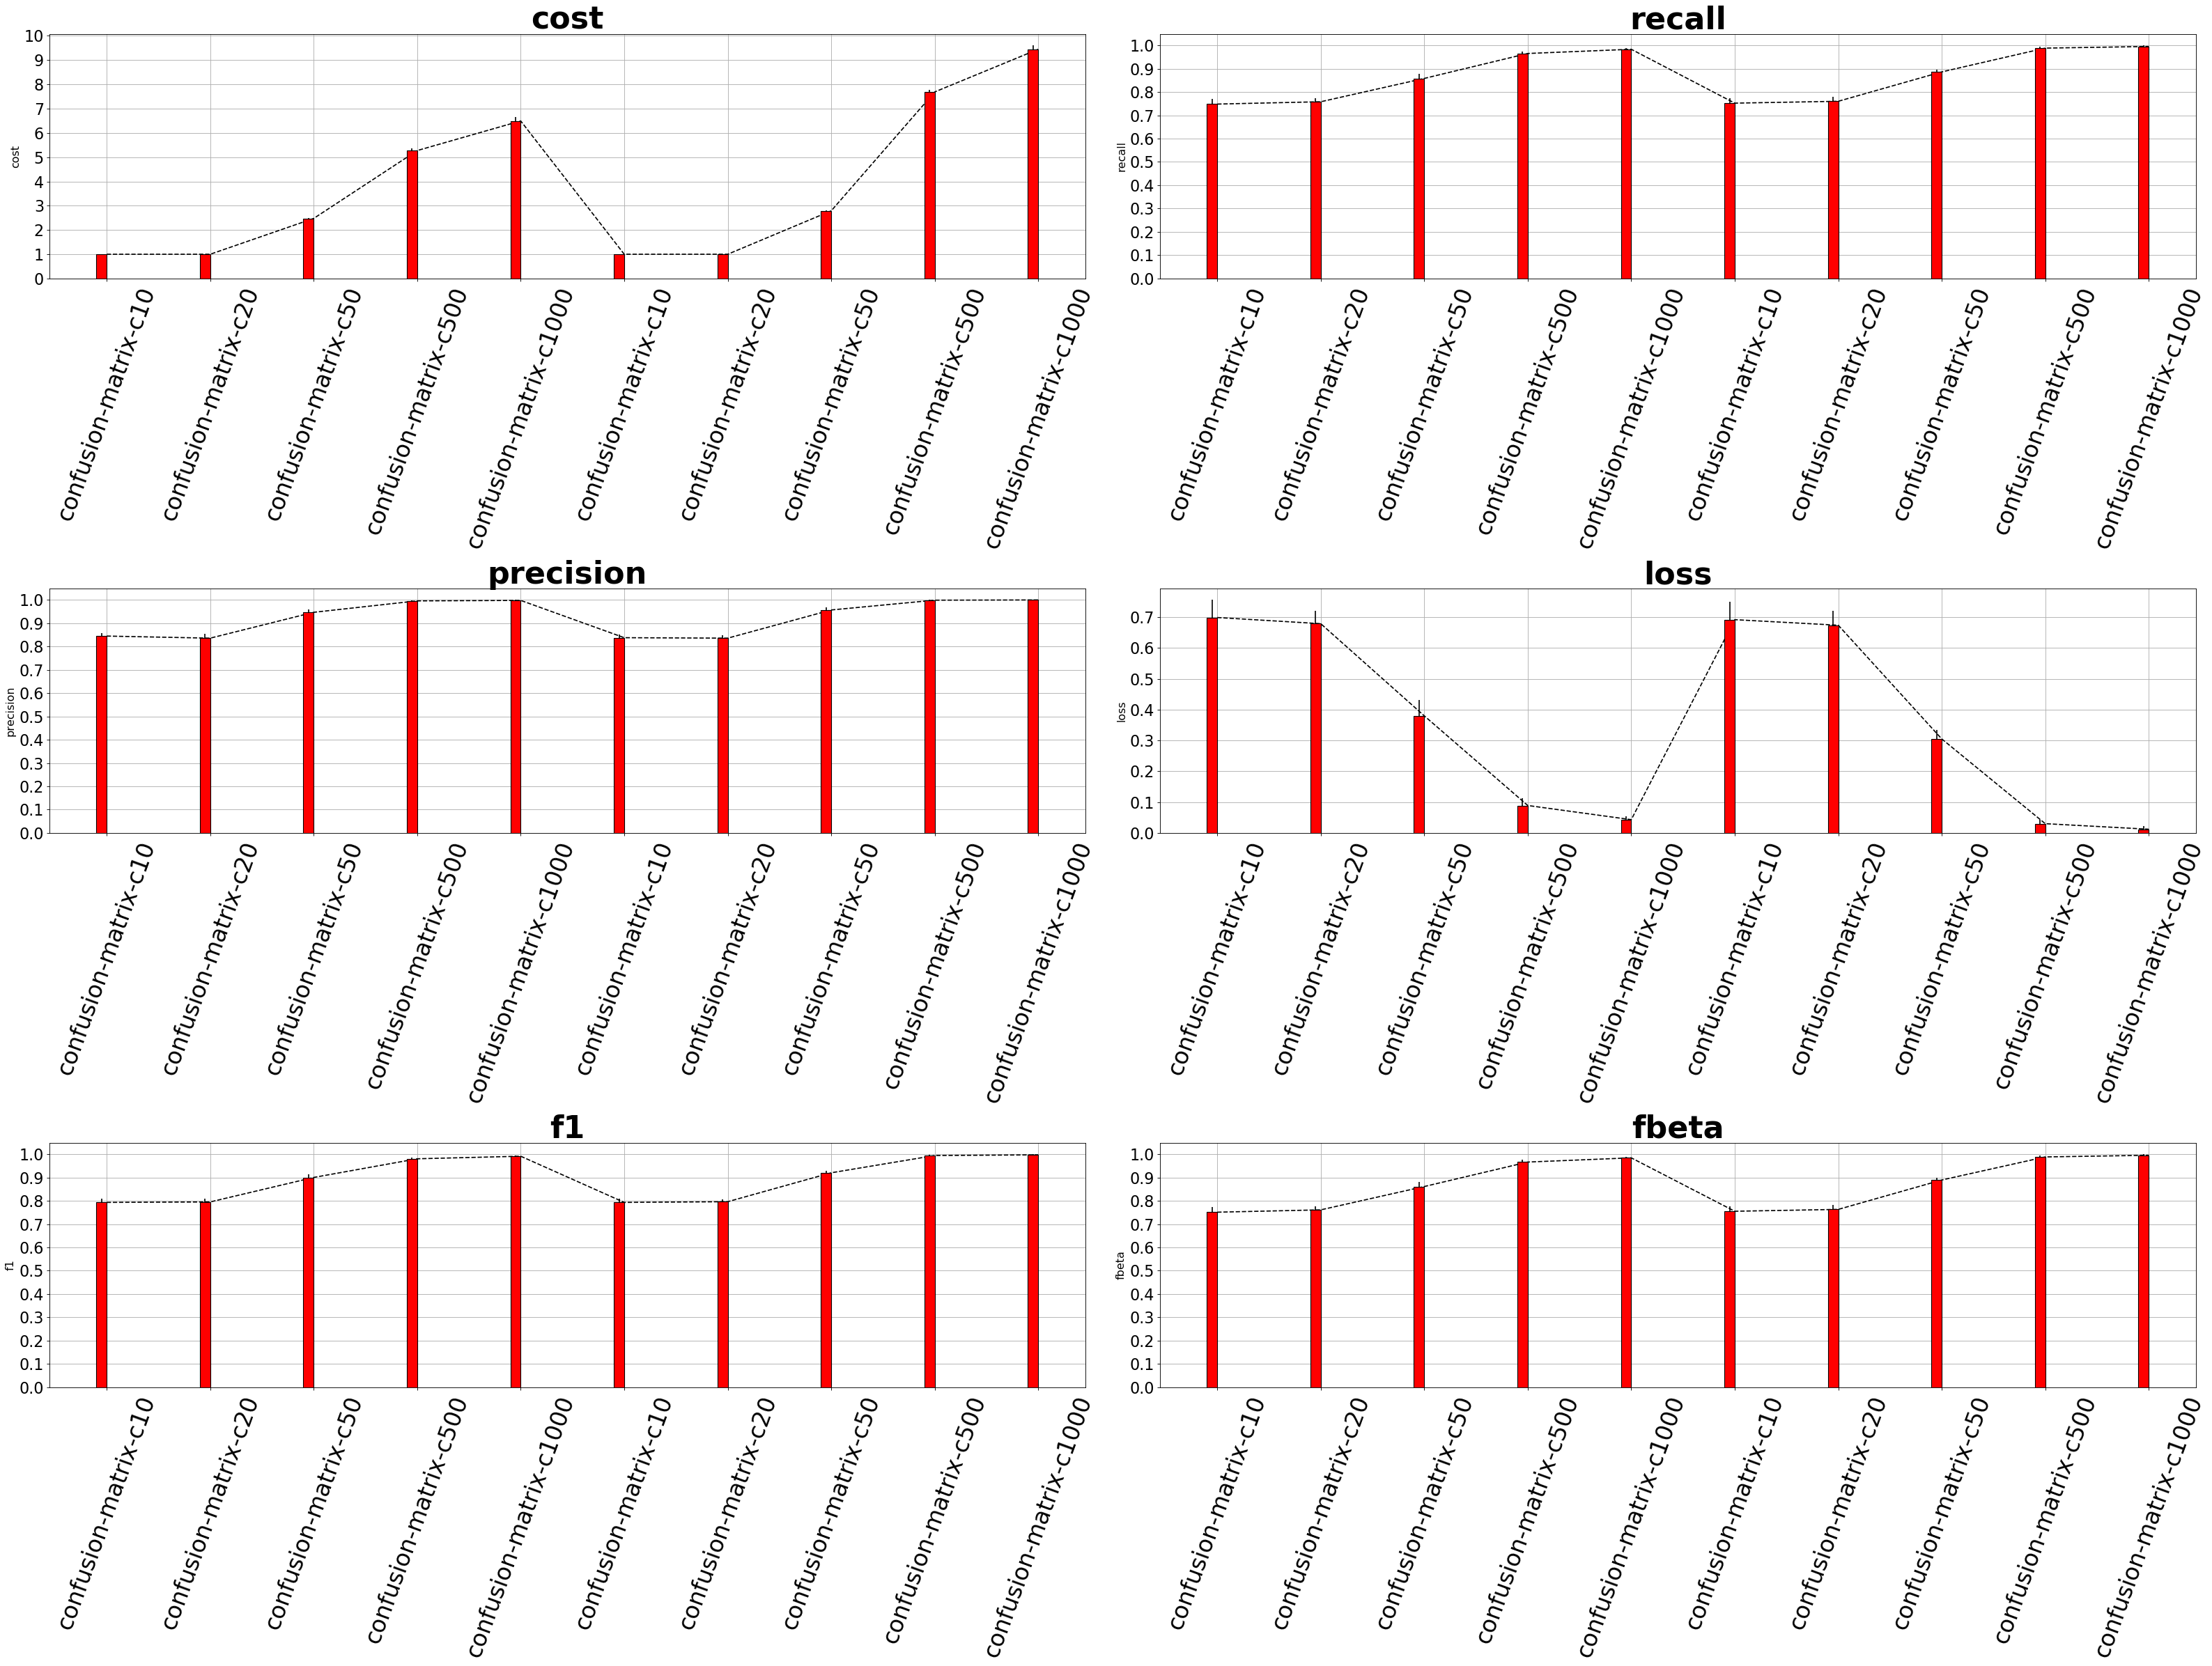

In [456]:
from IPython.core import display as ICD

print("Estimate after 2 votes")
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('confusion-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

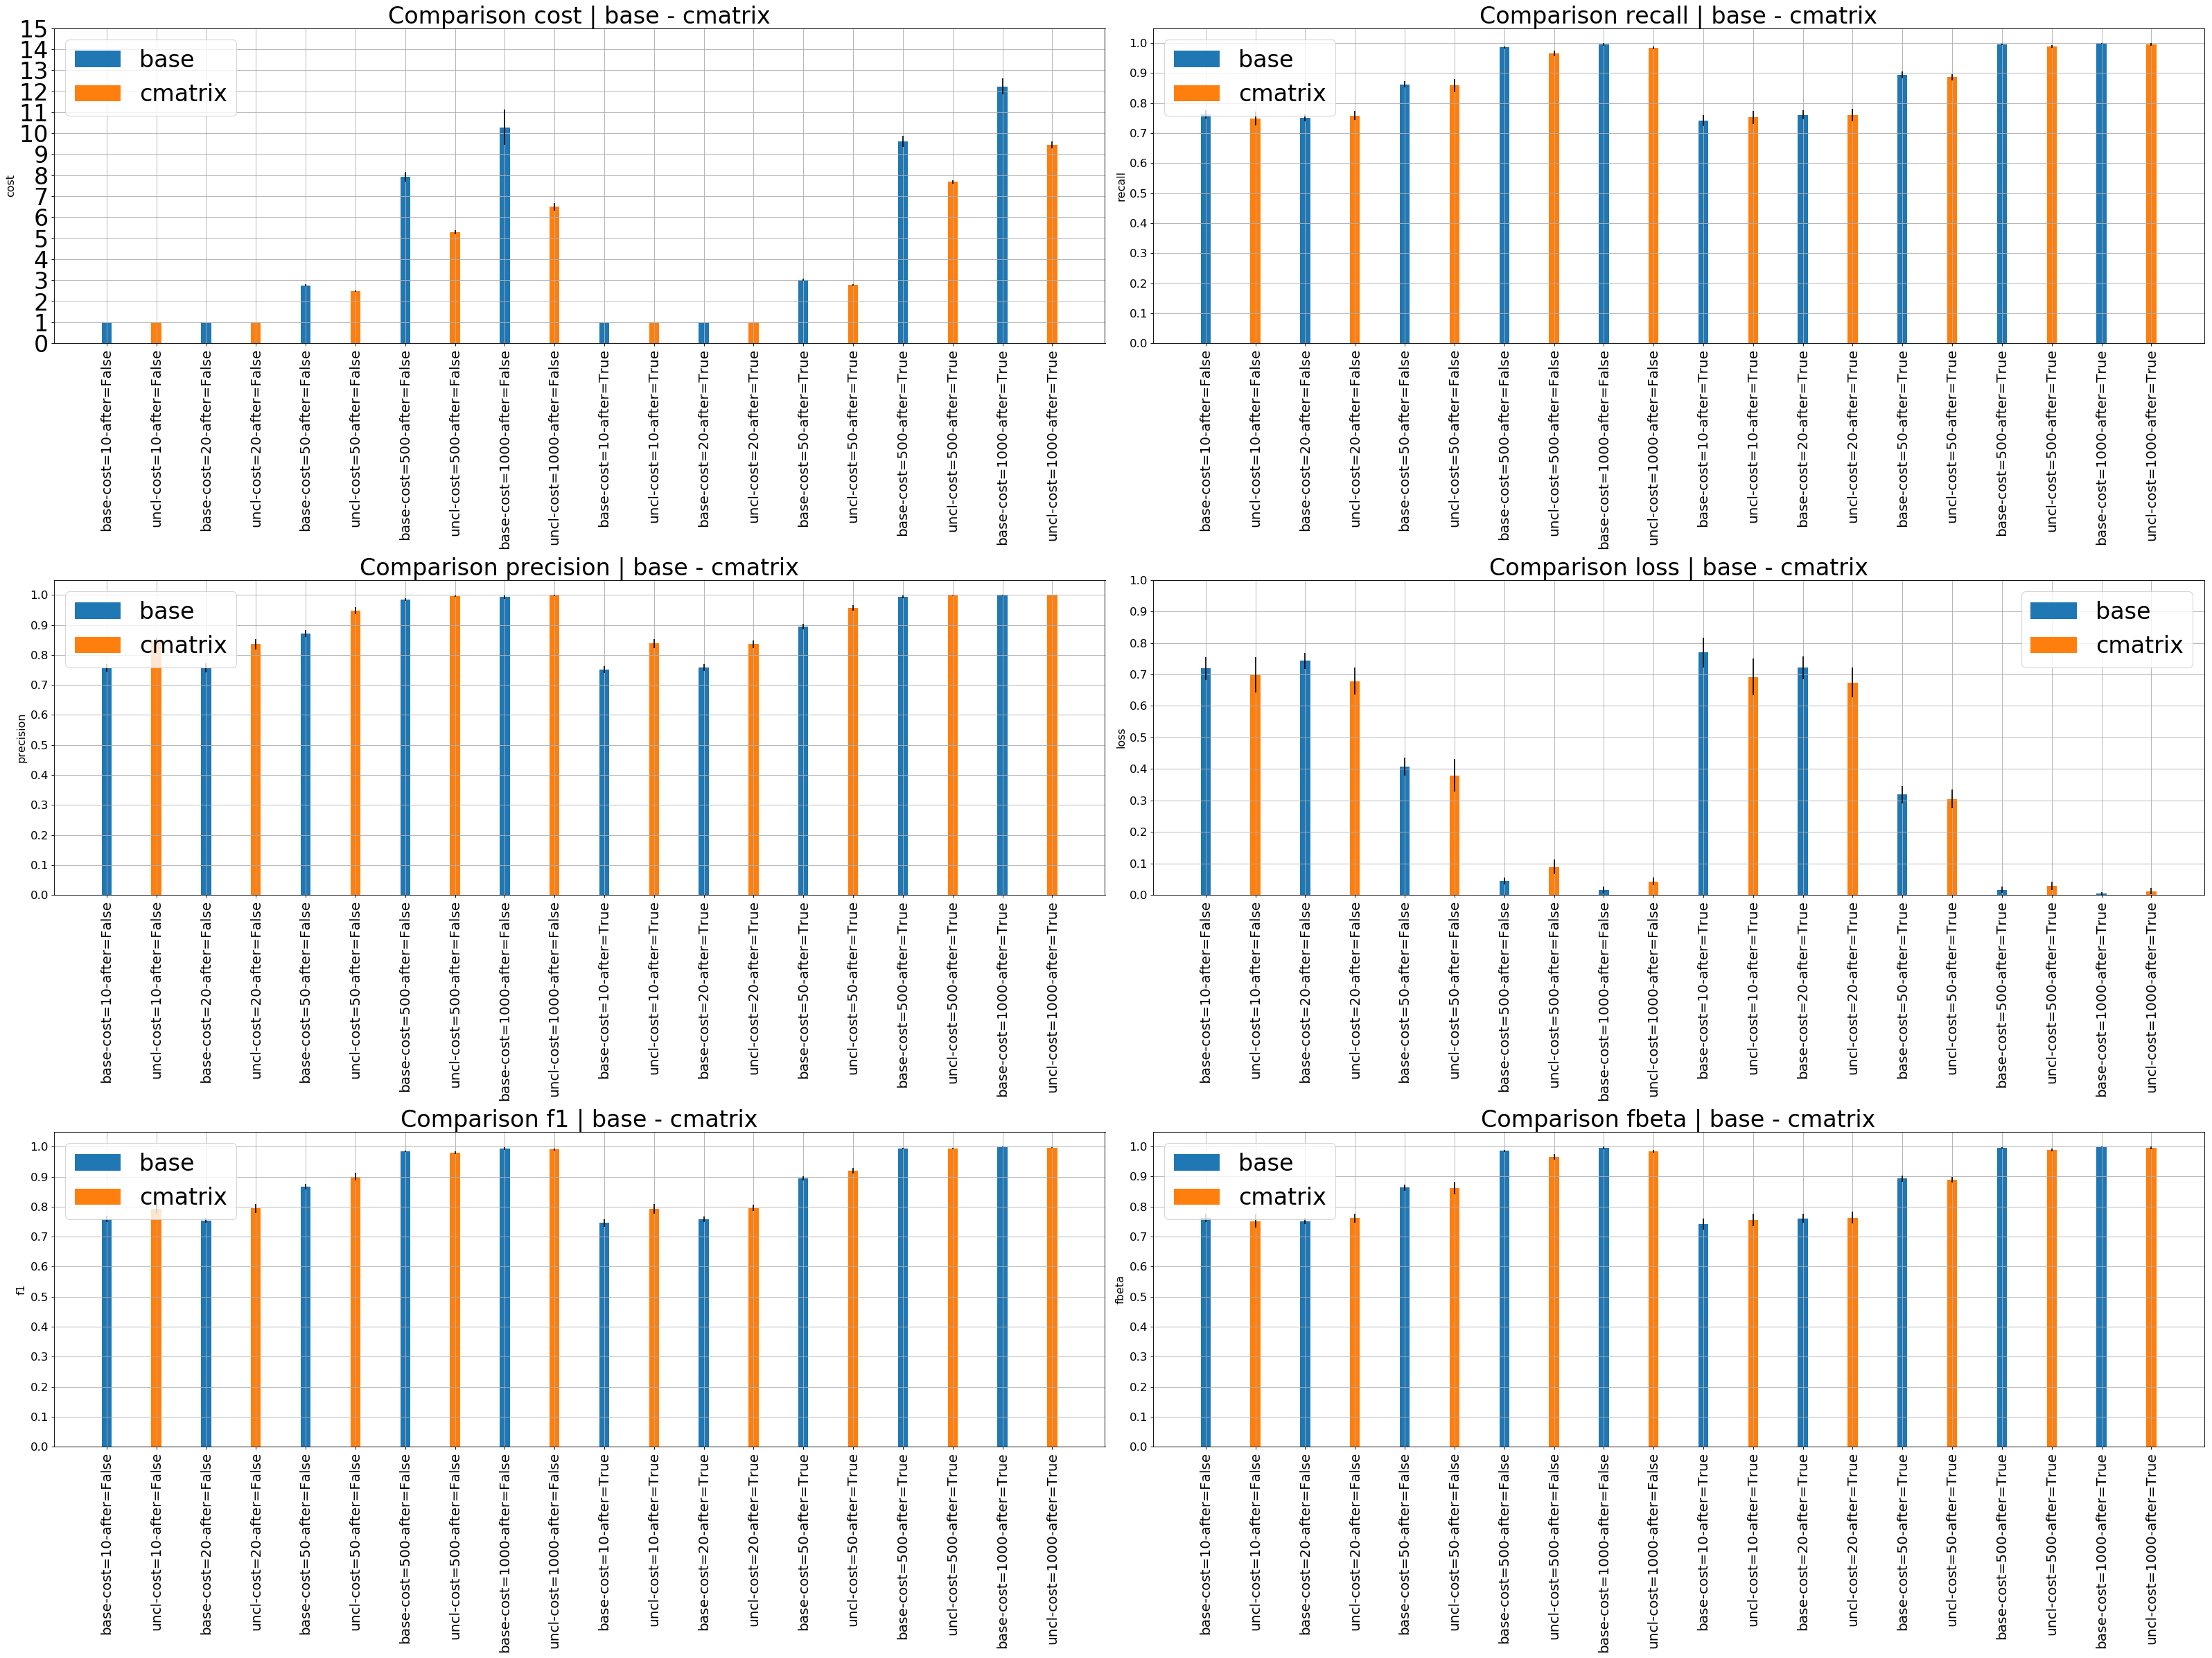

In [454]:
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')

elems_base = data[data.name.str.startswith('base-')]
elems_unc = data[data.name.str.startswith('confusion-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

plot_elems_comparisson(elems_base, elems_unc, 'base', 'cmatrix', columns)

#### Conclusions:
    - Representing workers accuracy with a confusion matrix reduces the money cost(less votes collected per item) and       
    similar(sometimes a bit higher) quality is obtained
    - The little increments can be explained because workers exclusion accuracy is 10% higher than inclusion

## 6. Dont update belief immediately using average error rate, first compute each worker error rate
- Using worker error rate with distribution Normal(1, 0.2)
- Change logic to the following procedure, for each item $i \in I$, and a set of workers $W$ :
    1. Request vote for an item i
    2. Collect a worker vote over item i
    3. Estimate worker error rate and item true label using EM
    4. Update belief state over item i


Estimate after 2 votes
         name  estimate_after    cost  recall  precision   loss     f1  fbeta
0    base-c10           False   1.000   0.762      0.757  0.719  0.759  0.761
1    base-c20           False   1.000   0.751      0.757  0.743  0.754  0.751
2    base-c50           False   2.763   0.862      0.872  0.408  0.867  0.863
3   base-c500           False   7.925   0.985      0.985  0.044  0.985  0.985
4  base-c1000           False  10.286   0.995      0.993  0.015  0.994  0.995
5    base-c10            True   1.000   0.741      0.751  0.770  0.746  0.741
6    base-c20            True   1.000   0.760      0.758  0.721  0.759  0.760
7    base-c50            True   3.020   0.893      0.894  0.319  0.894  0.893
8   base-c500            True   9.613   0.995      0.994  0.017  0.994  0.995
9  base-c1000            True  12.224   0.998      0.999  0.005  0.999  0.998


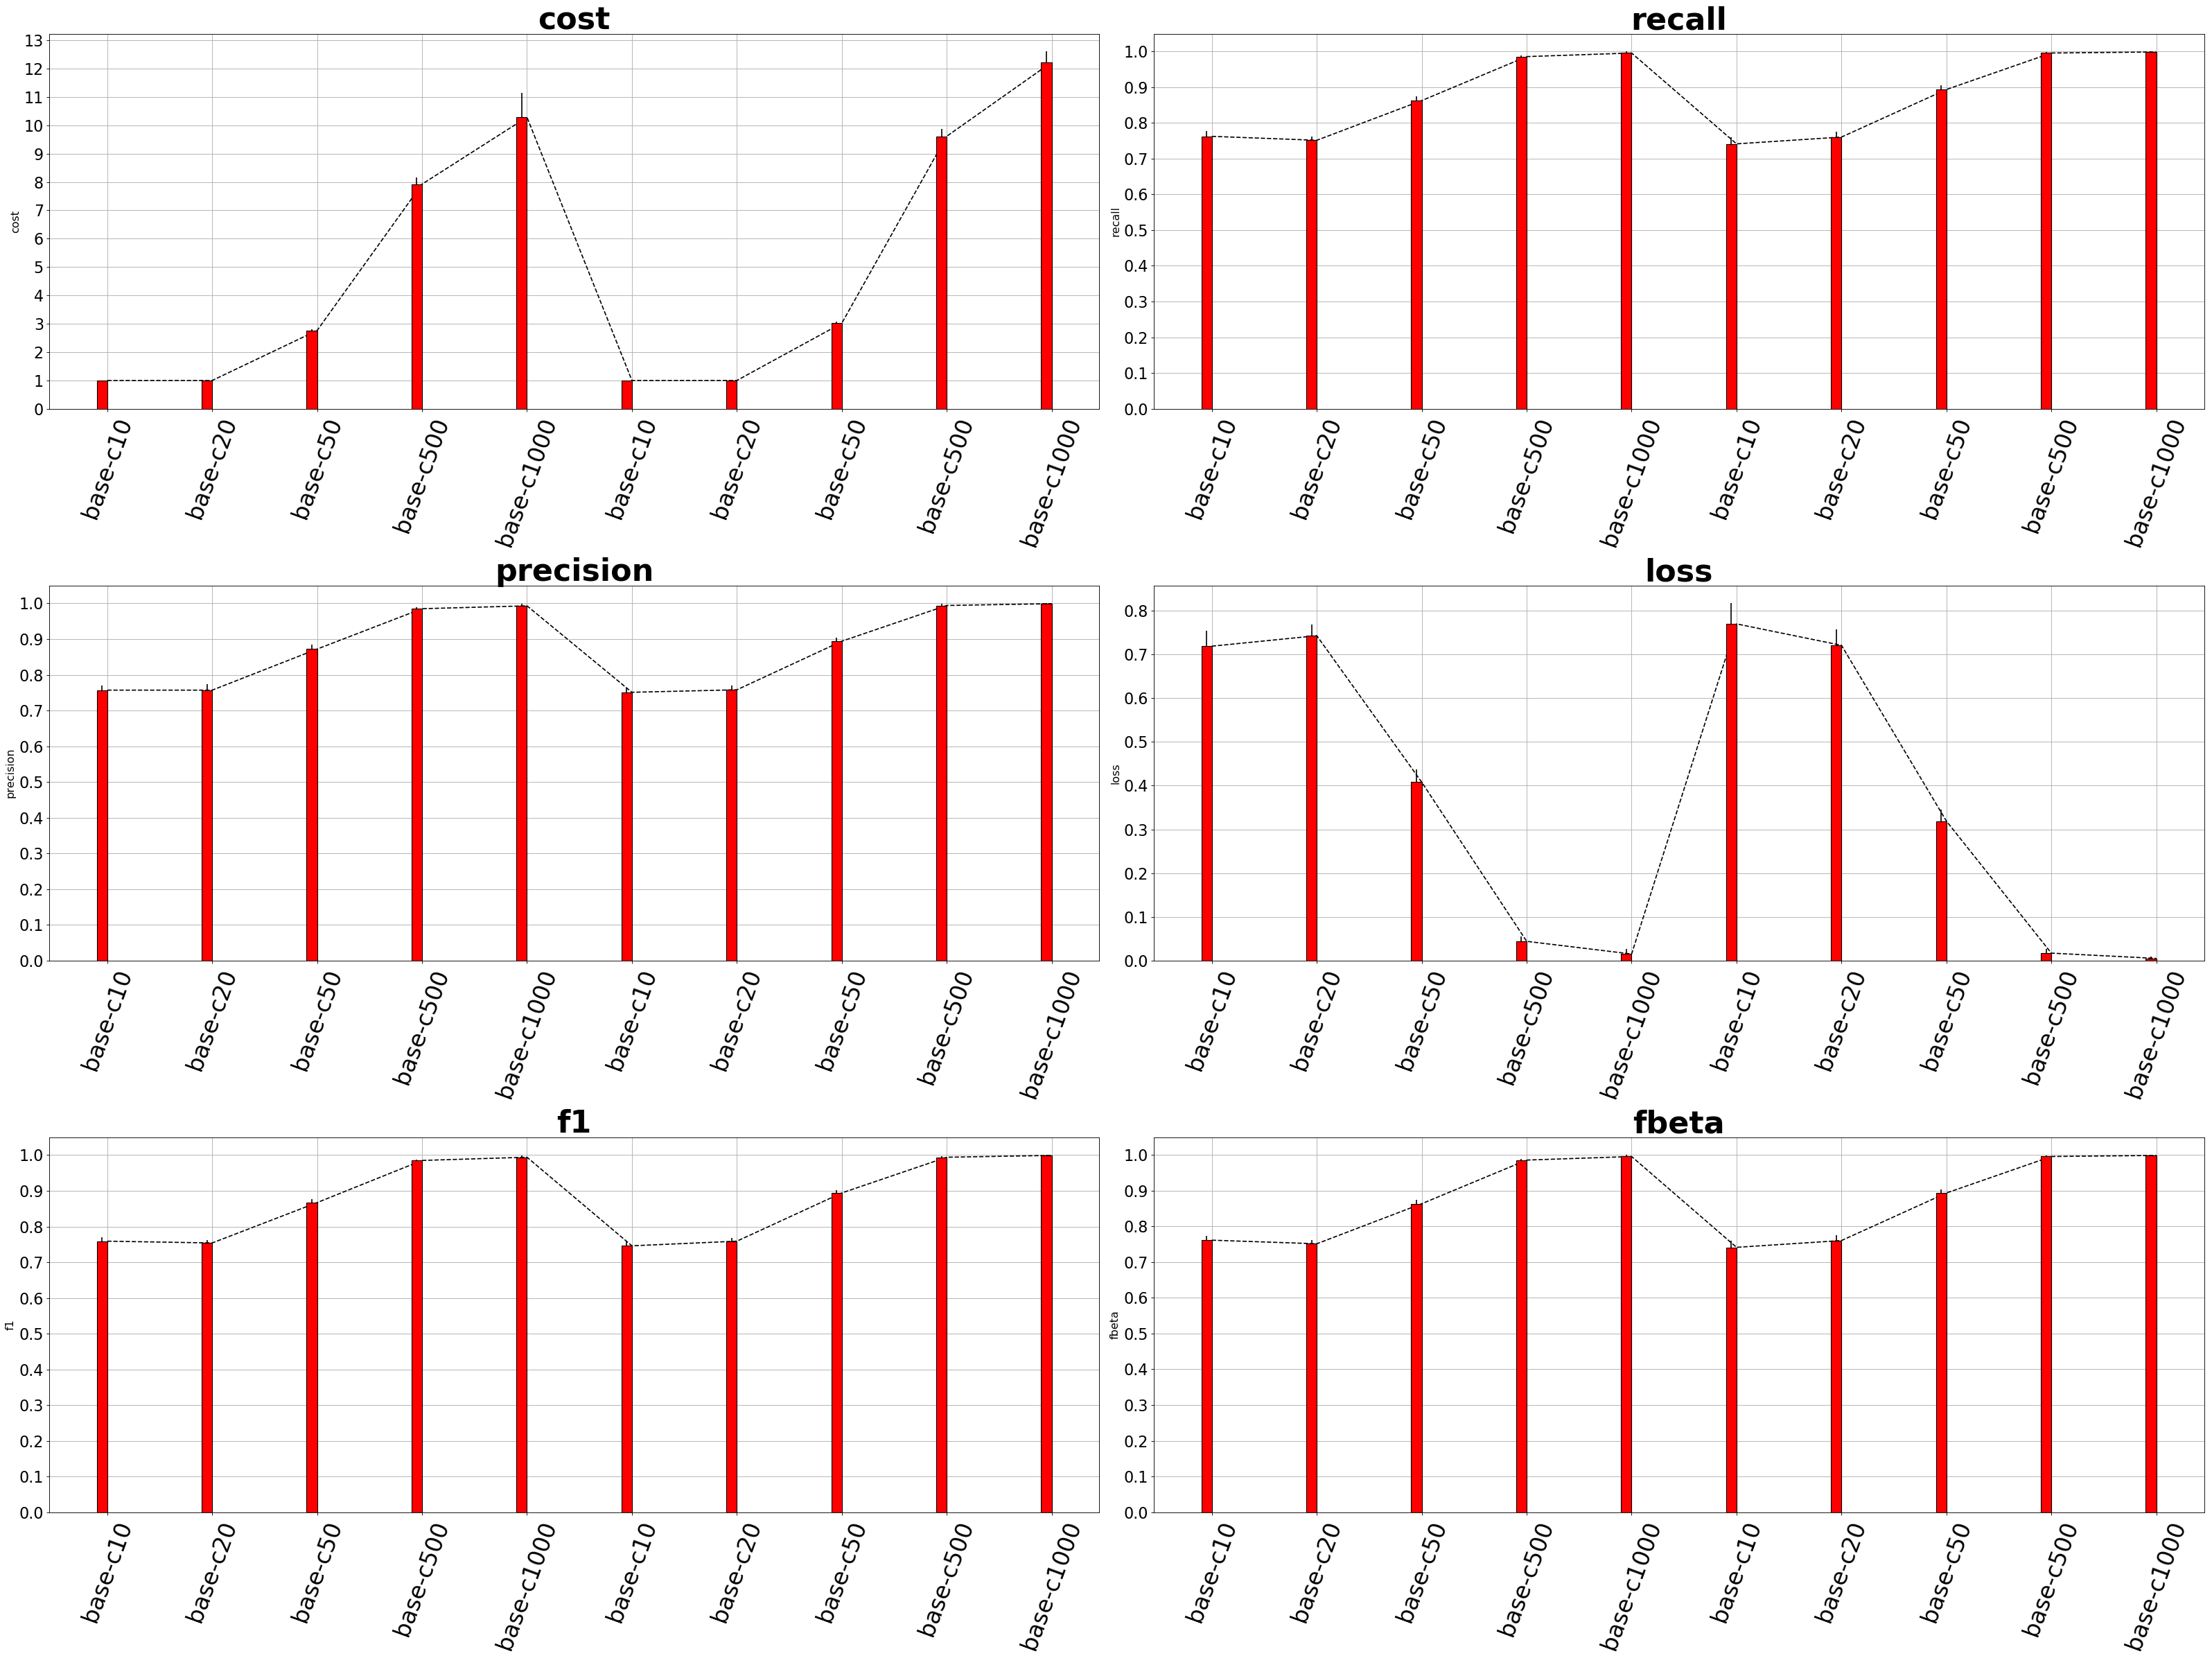

In [455]:
from IPython.core import display as ICD

print("Estimate after 2 votes")
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('base-')]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after']+columns])

plot_elems(elems, columns)

#### Conclusions:
    - Estimating workers error rate doesn't improve results
    - This can be caused because when the estimation is done many of the workers only voted over only 1 item
        - We would need to try changing the voting mechanism to make the same worker vote over a set(or all) the items

## 7. Try different dataset balances

### Results over differente balances, same wrong answer reward

Unbalanced
                name  estimate_after  data_bal   cost  recall  precision  \
130  unbalanced-c500            True      0.01  9.858   0.980      0.606   
140  unbalanced-c500            True      0.10  9.846   0.993      0.948   
150  unbalanced-c500            True      0.30  9.978   0.992      0.983   

      loss     f1  fbeta  
130  0.008  0.745  0.956  
140  0.009  0.970  0.991  
150  0.017  0.988  0.992  


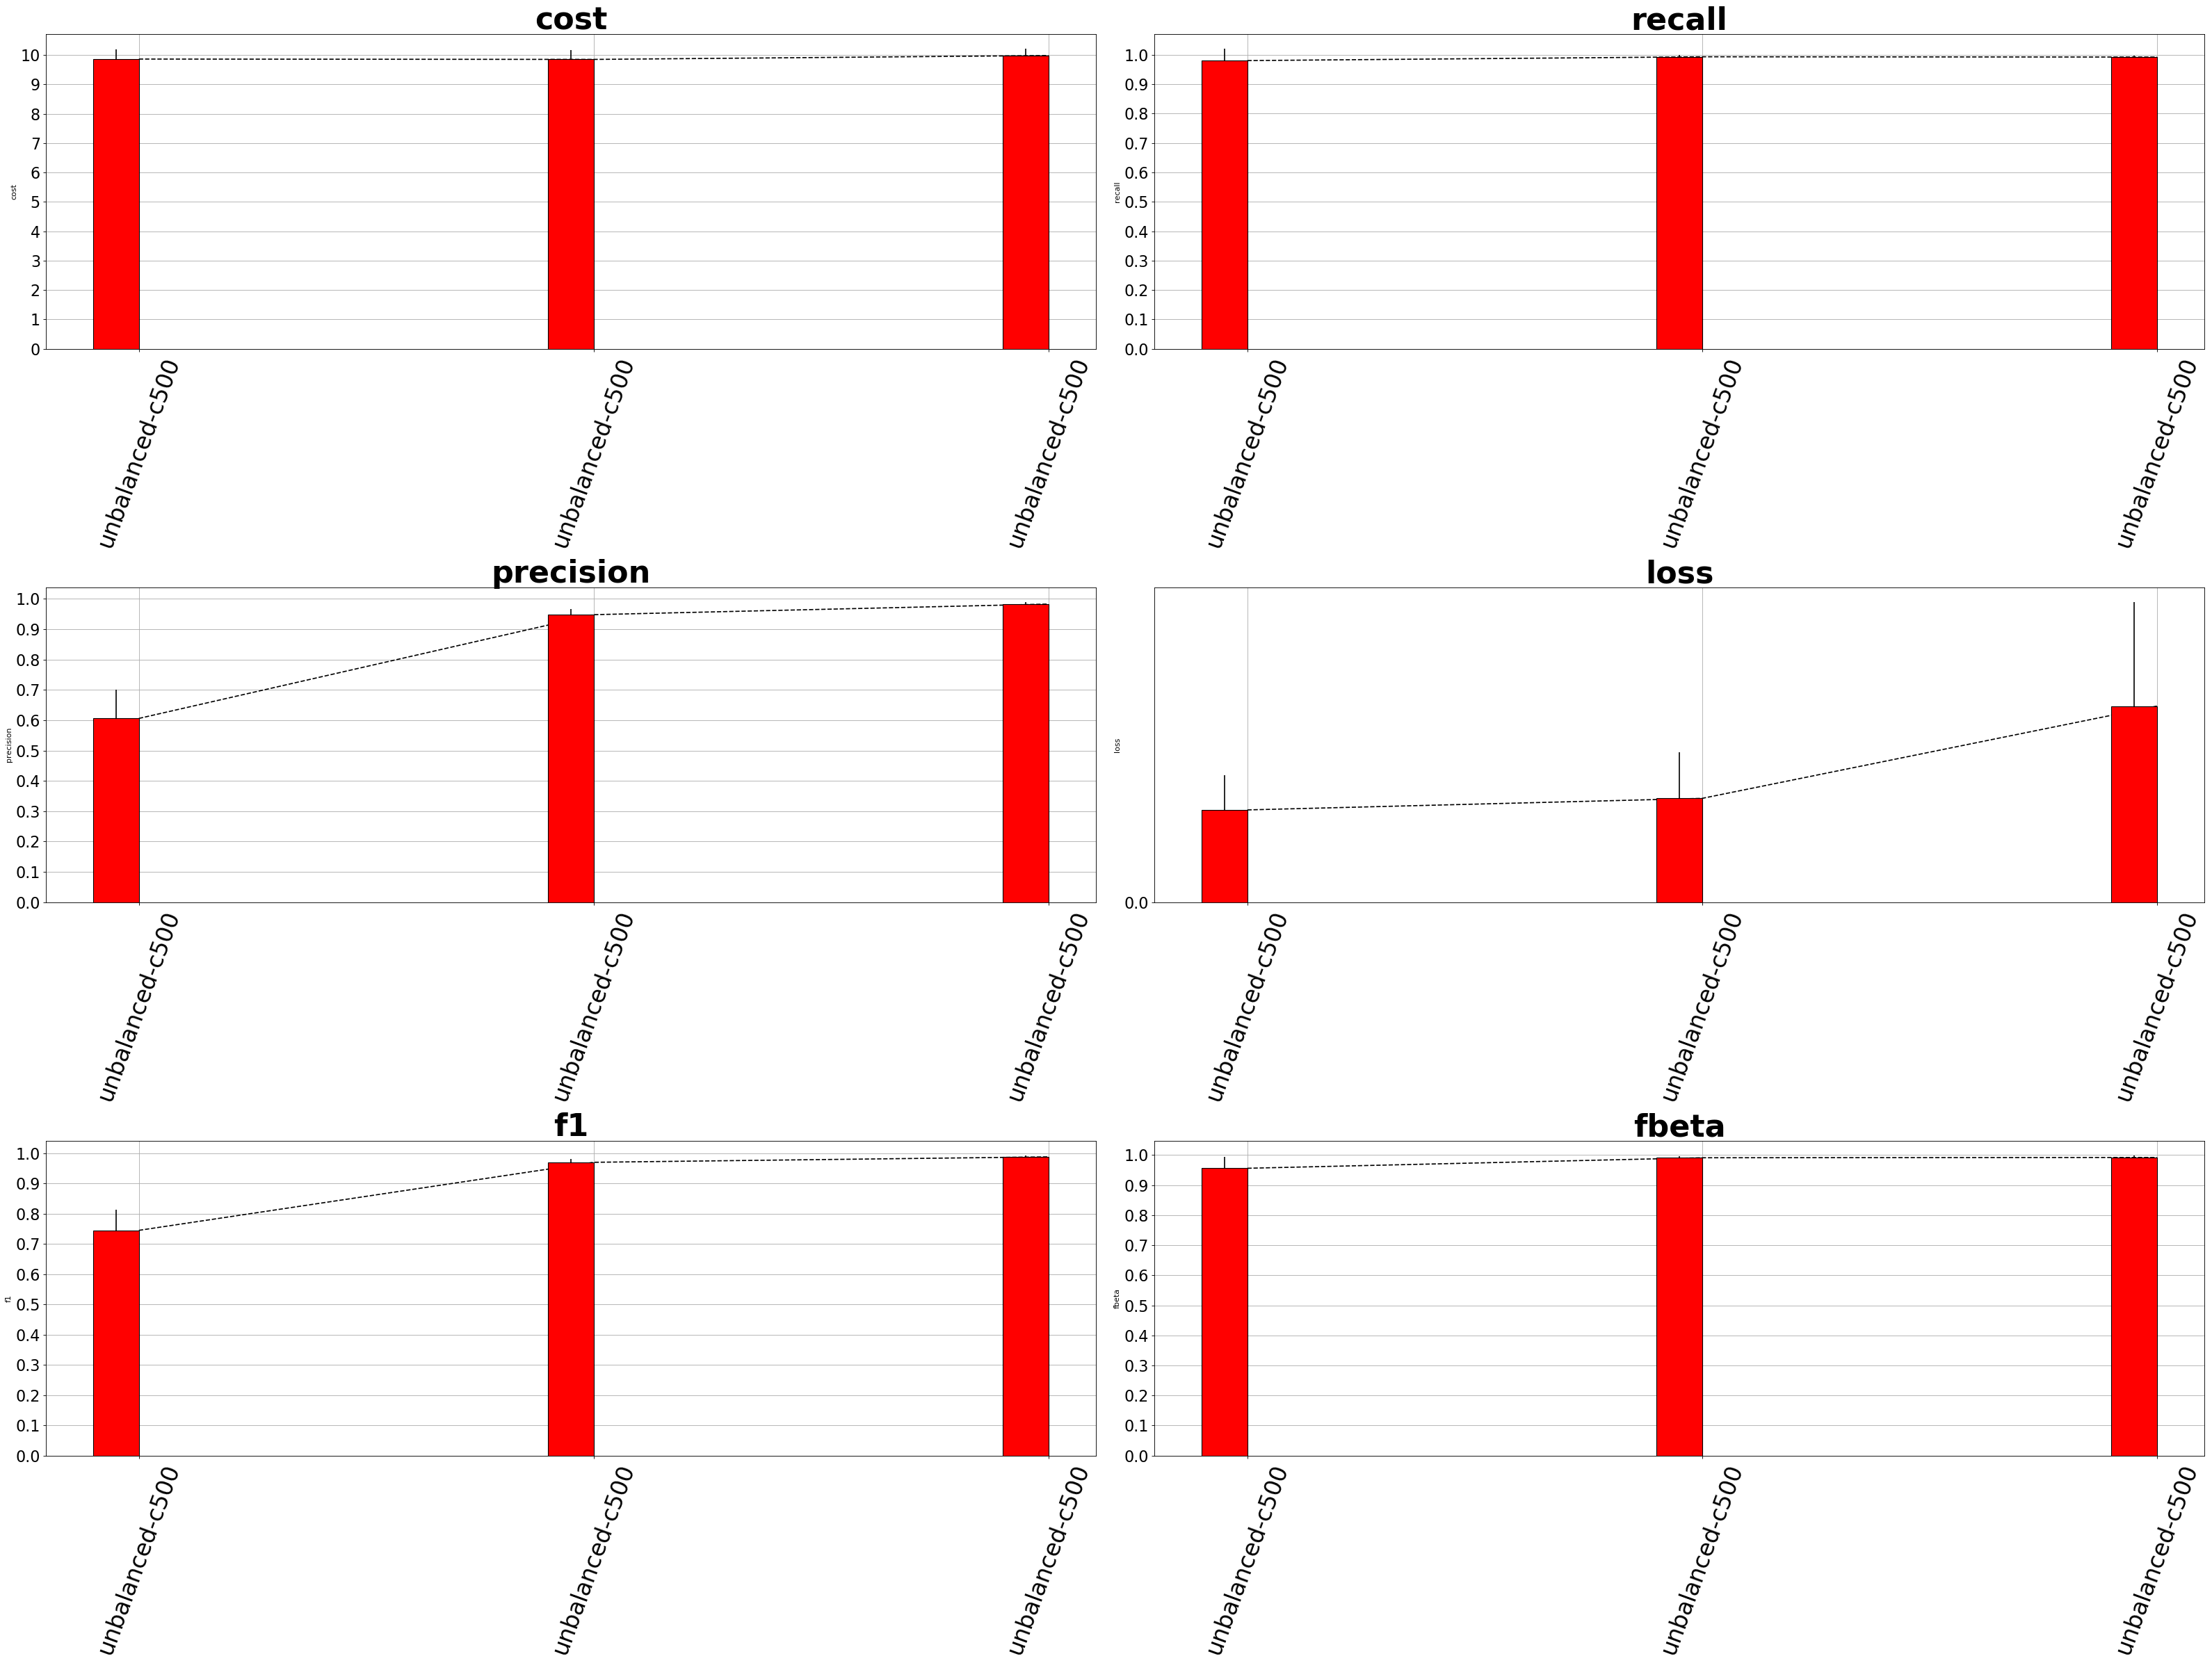

In [14]:
from IPython.core import display as ICD

print("Unbalanced")
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('unbalanced-')][data.wrong_cost == 500][data.estimate_after == True]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after','data_bal']+columns])

plot_elems(elems, columns)

### Results over same unbalance, different wrong answer rewards

Unbalanced
                 name  estimate_after  data_bal    cost  recall  precision  \
137    unbalanced-c10            True       0.1   1.000   0.756      0.255   
138    unbalanced-c20            True       0.1   1.000   0.752      0.248   
139    unbalanced-c50            True       0.1   2.993   0.896      0.470   
140   unbalanced-c500            True       0.1   9.846   0.993      0.948   
141  unbalanced-c1000            True       0.1  12.268   0.999      0.982   

      loss     f1  fbeta  
137  0.343  0.381  0.703  
138  0.352  0.373  0.697  
139  0.154  0.616  0.866  
140  0.009  0.970  0.991  
141  0.002  0.991  0.998  


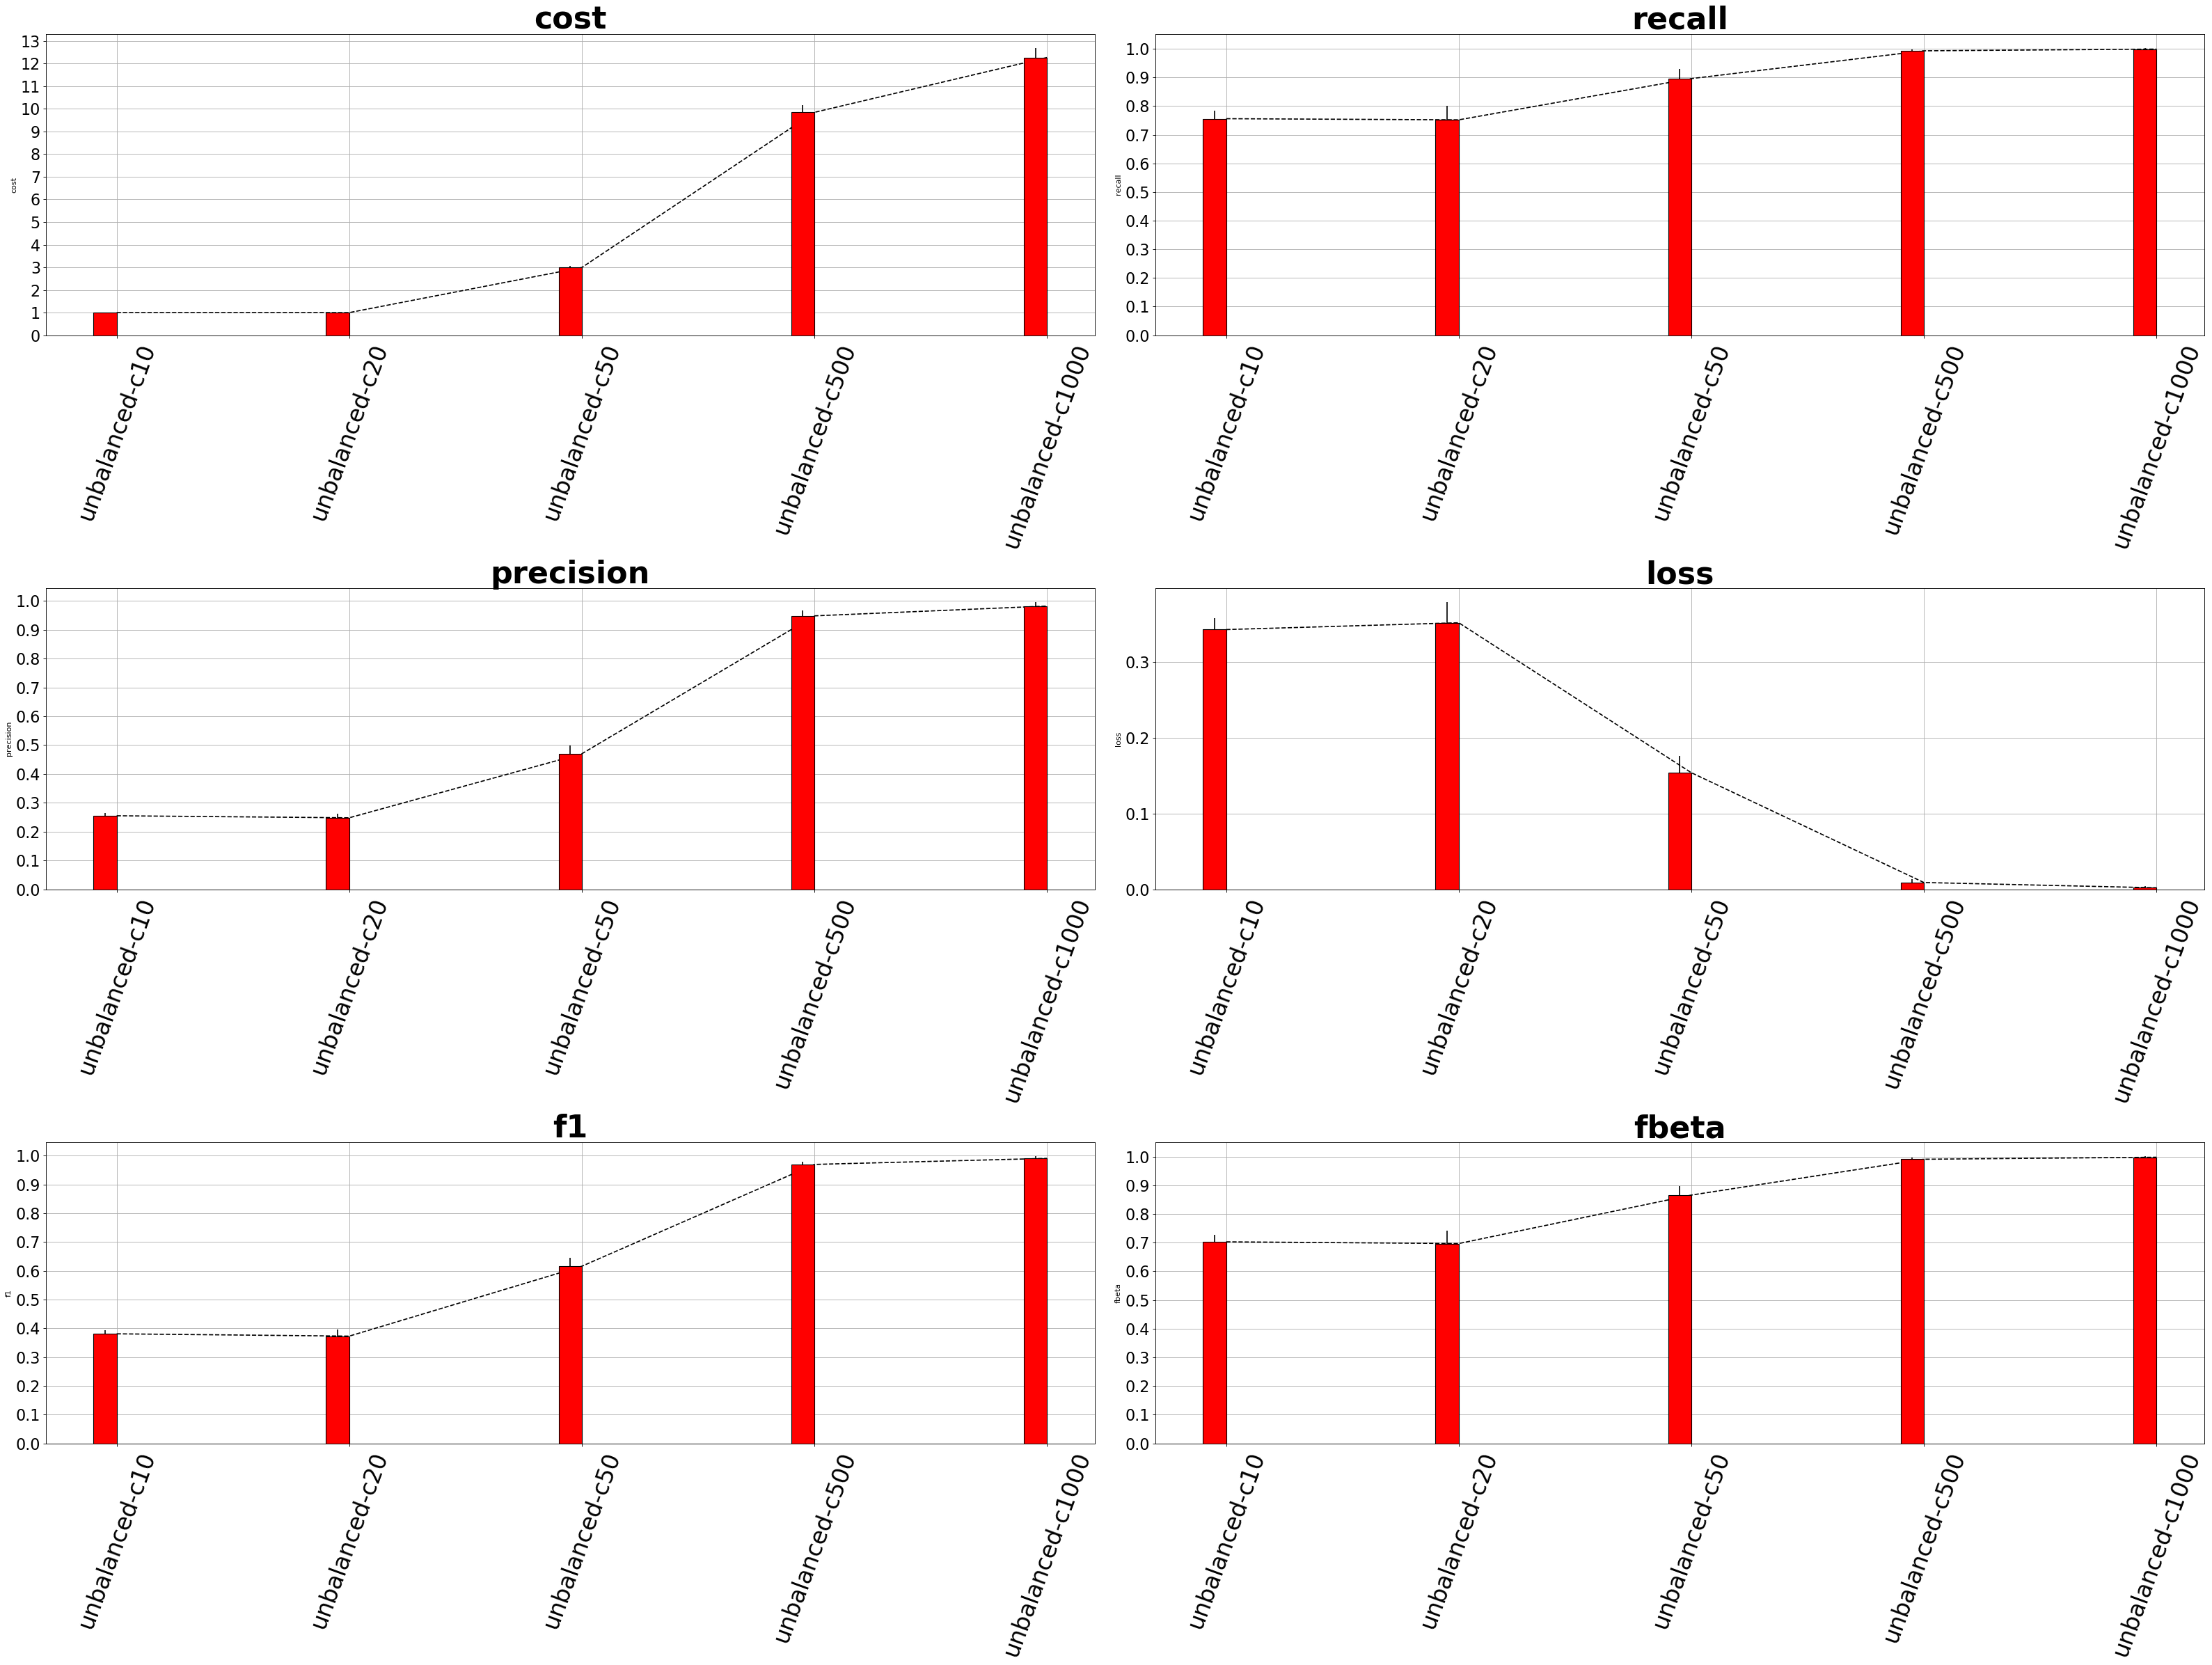

In [15]:
from IPython.core import display as ICD

print("Unbalanced")
data = pd.read_csv('/Users/pmaglione/Repos/adaptive-pomdp-solutions/dai_pomdp/results/pomdp_results.csv')
elems = data[data.name.str.startswith('unbalanced-')][data.estimate_after == True][data.data_bal == 0.1]

columns = ['cost', 'recall', 'precision', 'loss', 'f1', 'fbeta']

print(elems[['name', 'estimate_after','data_bal']+columns])

plot_elems(elems, columns)

## 8. Try to have an insight about next items belief state
- think in if we see a big % of items classified in a class and a new item arrives, the prob distribution over states should not be equally likely between all states

to-do